# Libraries

In [685]:
import pandas as pd
import numpy as np
import os
import matplotlib.font_manager as fm

# Plotting Libs
import matplotlib.pyplot as plt 
from sklearn.tree import plot_tree
from xgboost import plot_importance
import shap

# Statistical Libs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.feature_selection import SelectFromModel

# Collinearity / Feature Selection Libs 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

# Model Libs
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier


# Accuracy Libs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

# Resampling Libs
from imblearn.under_sampling import RandomUnderSampler



# Load Data

In [686]:
df1 = pd.read_pickle(r".\df_dummies\df1_dummies.pkl")
df2 = pd.read_pickle(r".\df_dummies\df2_dummies.pkl")
df3 = pd.read_pickle(r".\df_dummies\df3_dummies.pkl")
df4 = pd.read_pickle(r".\df_dummies\df4_dummies.pkl")


# Accuracy tests/ Roc Function


In [687]:
def accuracy(dfi, i, model, X_test, y_test, y_pred, title):
    print(f"Model : Phase {i} - {title}")
    
    print("\na).\nAccuracy Score : (True P + True N) / N total :")
    print(f"{accuracy_score(y_test, y_pred) * 100:.2f}%")

    print("\nb).\nClassification Report :")
    print(classification_report(y_test, y_pred))

    print("\n).\nMatthews Correlation Coefficient (MCC) :")
    print(matthews_corrcoef(y_test, y_pred))

    print("\nc).\nPlots :")
    fig , ax = plt.subplots(figsize = (20, 6), nrows = 1, ncols = 3)
    ConfusionMatrixDisplay.from_predictions(y_test , y_pred, ax = ax[0]);
    RocCurveDisplay.from_estimator(model, X_test, y_test, pos_label = 1, ax = ax[1], name = f'{title}');  # Completed = 0, Terminated = 1
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, pos_label=1, ax=ax[2], name=f'{title}')
    print(f"ROC AUC : {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]).round(2)}") # Predict Probabilities for accurate ROC Auc")
    print(f"PR AUC : {average_precision_score(y_test, model.predict_proba(X_test)[:, 1]).round(2)}")

    plt.suptitle(f"Phase {i} - {title}", fontsize = 11, fontweight = 'bold')

    # Confusion Matrix
    ax[0].set_title("1. Confusion Matrix", fontsize = 10, fontweight = 'bold')
    ax[0].set_xlabel("Predicted Label", fontsize = 10, fontweight = 'bold')
    ax[0].set_ylabel("True Label", fontsize = 10, fontweight = 'bold')
    
    # Roc Curve
    ax[1].set_title("2. ROC Curve" , fontsize = 10, fontweight = 'bold')
    ax[1].set_ylabel("TPR - Sensitivity - Recall", fontsize = 10, fontweight = 'bold')
    ax[1].set_xlabel("FPR - (1 - Specificity)", fontsize = 10, fontweight = 'bold')

    # PR Cruve
    ax[2].set_title("3. PR Curve", fontsize=10, fontweight='bold')
    ax[2].set_ylabel("PPV - Precision", fontsize=10, fontweight='bold')
    ax[2].set_xlabel("TPR - Sensitivity - Recall", fontsize=10, fontweight='bold')

    plt.show()      
    plt.close(fig)  

# Data Preparation

## Df Input

In [688]:
display(df1.shape)
display(df2.shape)
display(df3.shape)
display(df4.shape)


(27324, 128)

(29260, 128)

(16503, 128)

(13246, 129)

In [689]:
i = 4
dfi = df4

## X , y

In [690]:
X = dfi.drop("Study_Status_Bin", axis = 1)
y = dfi["Study_Status_Bin"]

# initial X features
X.shape # Check that initial shape of dfi was not changed.

(13246, 128)

## Train - Test Split

In [691]:
# Train-Test Split
X_train_tts, X_test_tts, y_train_tts, y_test_tss = train_test_split(X, y, test_size = 0.12, stratify = y, random_state = 42)
y_train_tts.value_counts().iloc[1]/y_train_tts.value_counts().iloc[0] # Imbalanced 0 row = Compeleted, row 1 = terminated

0.2111388196176226

## Resample
- Datasets are imbalanced towards the positive class. (i.e. COMPLETED = 1)
- Resample train set only, so model will be correctly trained (not biased towards the most common category of Study_Status).
    --> Avoids information leaking to test set. test set always similar to true cases.
- Performance evaluated on unsampled test set, with real data percentages per category.

In [692]:
res = RandomUnderSampler(sampling_strategy = 'auto', random_state = 42)
X_train_res, y_train_res = res.fit_resample(X_train_tts, y_train_tts) 

# Final train/test ratio
display(f'X_test/X_train : {X_test_tts.shape[0]}/{X_train_res.shape[0]} = {(X_test_tts.shape[0]/X_train_res.shape[0])}')
display(X_train_res.shape[1], X_train_res.shape[1]/X_train_res.shape[0])

'X_test/X_train : 1590/4064 = 0.391240157480315'

128

0.031496062992125984

## Scaling

In [556]:
def fun_scale(X_train_sc_par, X_test_sc_par):  # Scaling always after dataset split

    X_train_sc = X_train_sc_par.copy()
    X_test_sc = X_test_sc_par.copy()

    cont_cols = [col for col in X_train_sc.columns 
                    if (('count' in col.lower() or 'log' in col.lower()) and
                        not any(x in col.lower() for x in ['bin', 'categ', 'list']))]
    if cont_cols:
        scaler = StandardScaler(with_mean = False, with_std = True)

        X_train_sc[cont_cols] = pd.DataFrame(scaler.fit_transform(X_train_sc[cont_cols]),
            columns = cont_cols, index=X_train_sc.index)

        X_test_sc[cont_cols] = pd.DataFrame(scaler.transform(X_test_sc[cont_cols]),
            columns = cont_cols, index=X_test_sc.index)
    else:
        print("No continuous/log columns to scale.")

    return X_train_sc, X_test_sc

X_train_sc, X_test_sc = fun_scale(X_train_res, X_test_tts)


## X_train , X_test

In [558]:
def fun_rename(X_train, X_test, y_train, y_test):

    X_train.columns = X_train.columns.str.replace(r'List_|Detail_|_Bin|Adv_Syst_|Adv_', "", regex=True)
    X_train.columns = X_train.columns.str.replace(r'Counts_Log', "Log", regex=True)
    X_train.columns = X_train.columns.str.replace(r'Funder_Type', "Funder", regex=True)
    X_train.columns = X_train.columns.str.replace(r'_', " ", regex=True)

    X_test.columns = X_test.columns.str.replace(r'List_|Detail_|_Bin|Adv_Syst_|Adv_', "", regex=True)
    X_test.columns = X_test.columns.str.replace(r'Counts_Log', "Log", regex=True)
    X_test.columns = X_test.columns.str.replace(r'Funder_Type', "Funder", regex=True)
    X_test.columns = X_test.columns.str.replace(r'_', " ", regex=True)

    y_train.name = y_train.name.replace('Study_Status_Bin', 'Study Status')
    y_test.name = y_test.name.replace('Study_Status_Bin', 'Study Status')

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = fun_rename(X_train_sc, X_test_sc, y_train_res, y_test_tss)

X_train.columns.to_list()

['Completion Gap Log',
 'Placebo',
 'Standard Care',
 'Healthy',
 'Covid 19',
 'Adverse Log',
 'Adverse',
 'Adverse System Log',
 'Arm Log',
 'Countries Log',
 'City Log',
 'Enrollment Log',
 'Intervention Type Categ',
 'Intervention Route Categ',
 'Sex FEMALE',
 'Sex MALE',
 'Age ADULT',
 'Age OLDER ADULT',
 'Funder GOVERM',
 'Funder INDUSTRY',
 'Intervention Type BEHAVIORAL',
 'Intervention Type BIOLOGICAL',
 'Intervention Type COMBINATION PRODUCT',
 'Intervention Type DEVICE',
 'Intervention Type DIAGNOSTIC TEST',
 'Intervention Type DIETARY SUPPLEMENT',
 'Intervention Type DRUG',
 'Intervention Type GENETIC',
 'Intervention Type PROCEDURE',
 'Intervention Type RADIATION',
 'Intervention Route Injection',
 'Intervention Route Oral',
 'Intervention Route Surgical',
 'Intervention Route Topical',
 'Conditions Bacterial Infections and Mycoses',
 'Conditions Cardiovascular',
 'Conditions Chemical Disorders',
 'Conditions Digestive System, Nutritional, Metabolic',
 'Conditions Education'

##  Penalties

## MI 
- Info overlap (nonlinear)
- Mutual information (MI) 1 between two random variables is a non-negative value, which measures the dependency between the variables.

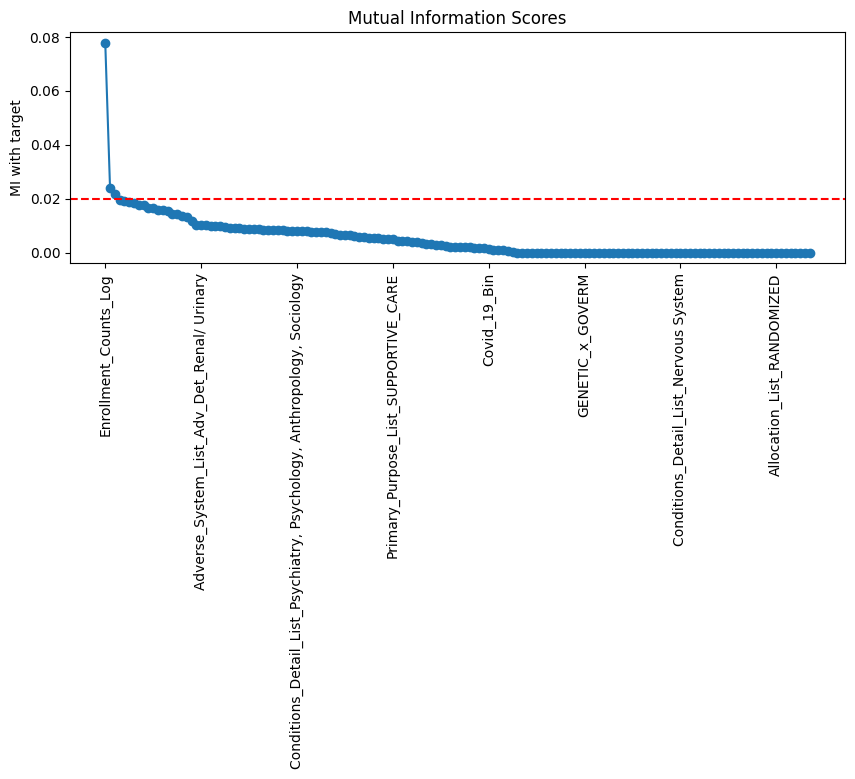

86

In [428]:
mi_scores = mutual_info_classif(X_train, y_train, random_state = 42)
mi = pd.Series(mi_scores, index = X_train.columns)
kept_cols = mi[mi > 0].index # If threshold is too strict and drops everything, keep the best one to avoid empty matrix

if len(kept_cols) == 0: 
    kept_cols = [mi.idxmax()] 

X_train_mi = X_train.loc[:, kept_cols].copy() 
X_test_mi = X_test.loc[:, kept_cols].copy()
    
mi_series = pd.Series(mi_scores, index = X_train.columns).sort_values(ascending=False)

plt.figure(figsize = (10, 3))
mi_series.plot(marker = 'o')
plt.axhline(0.02, color = 'red', linestyle = '--')  # example threshold
plt.title("Mutual Information Scores")
plt.ylabel("MI with target")
plt.xticks(rotation = 90)
plt.show()

display(X_train_mi.shape[1])

# Models

## A) Classic Classification

### Logistic (L1)

In [429]:
X_train_log = X_train.copy()
X_test_log = X_test.copy()
y_train_log = y_train.copy()
y_test_log = y_test.copy()

display(X_train_log.shape[1])

148

Model : Phase 3 - Lasso Logistic Regression (L1)

a).
Accuracy Score : (True P + True N) / N total :
70.80%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.72      0.81       910
           1       0.26      0.66      0.37       138

    accuracy                           0.71      1048
   macro avg       0.60      0.69      0.59      1048
weighted avg       0.84      0.71      0.75      1048


).
Matthews Correlation Coefficient (MCC) :
0.2687223395684515

c).
Plots :
ROC AUC : 0.77
PR AUC : 0.44


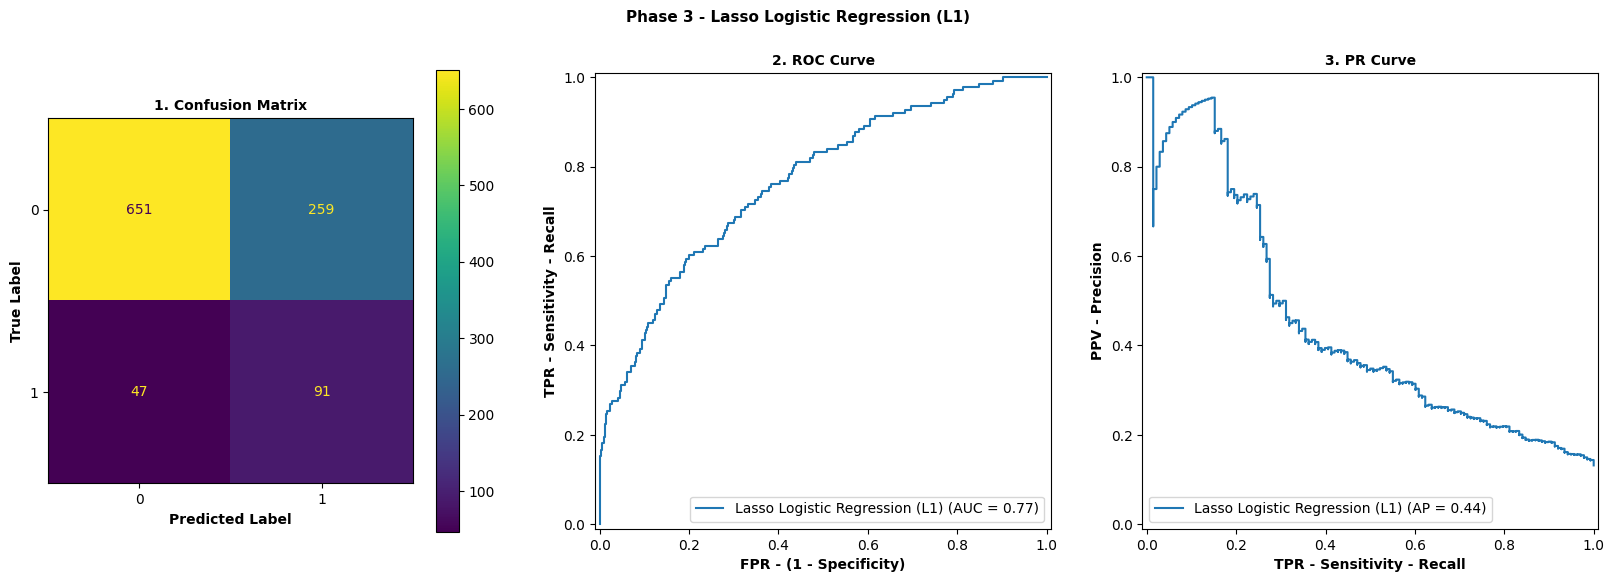

In [439]:
# Model
log_reg = LogisticRegression(penalty = 'l1', max_iter = 5000 , solver = 'saga', class_weight = 'balanced',  random_state = 42)  
# Final Model
log_model = log_reg.fit(X_train, y_train)
# y_pred
y_pred_log_l1 = log_model.predict(X_test)
# Accuracy Score
accuracy(dfi, i, log_model, X_test, y_test, y_pred_log_l1, "Lasso Logistic Regression (L1)")


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_39440\3878724574.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_log_sam, plot_size = (10, 5), show = False)


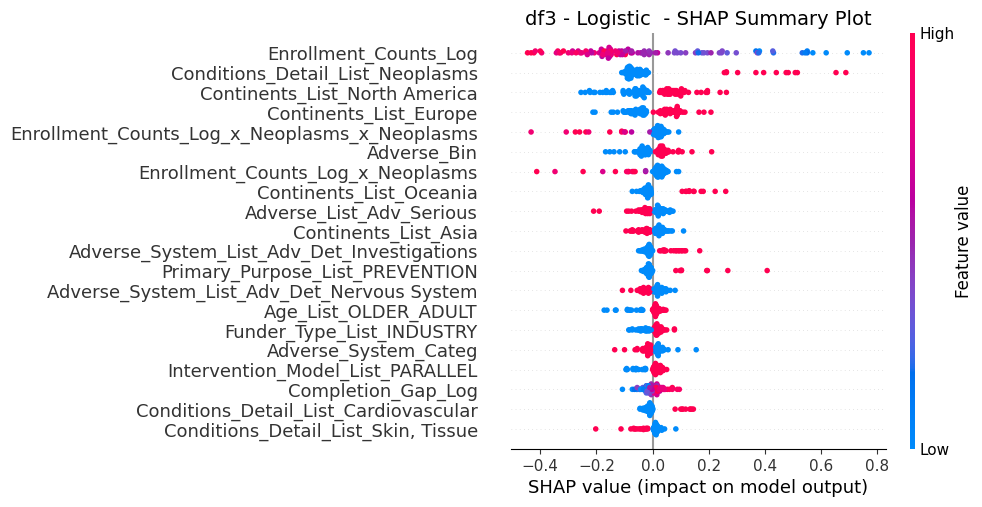

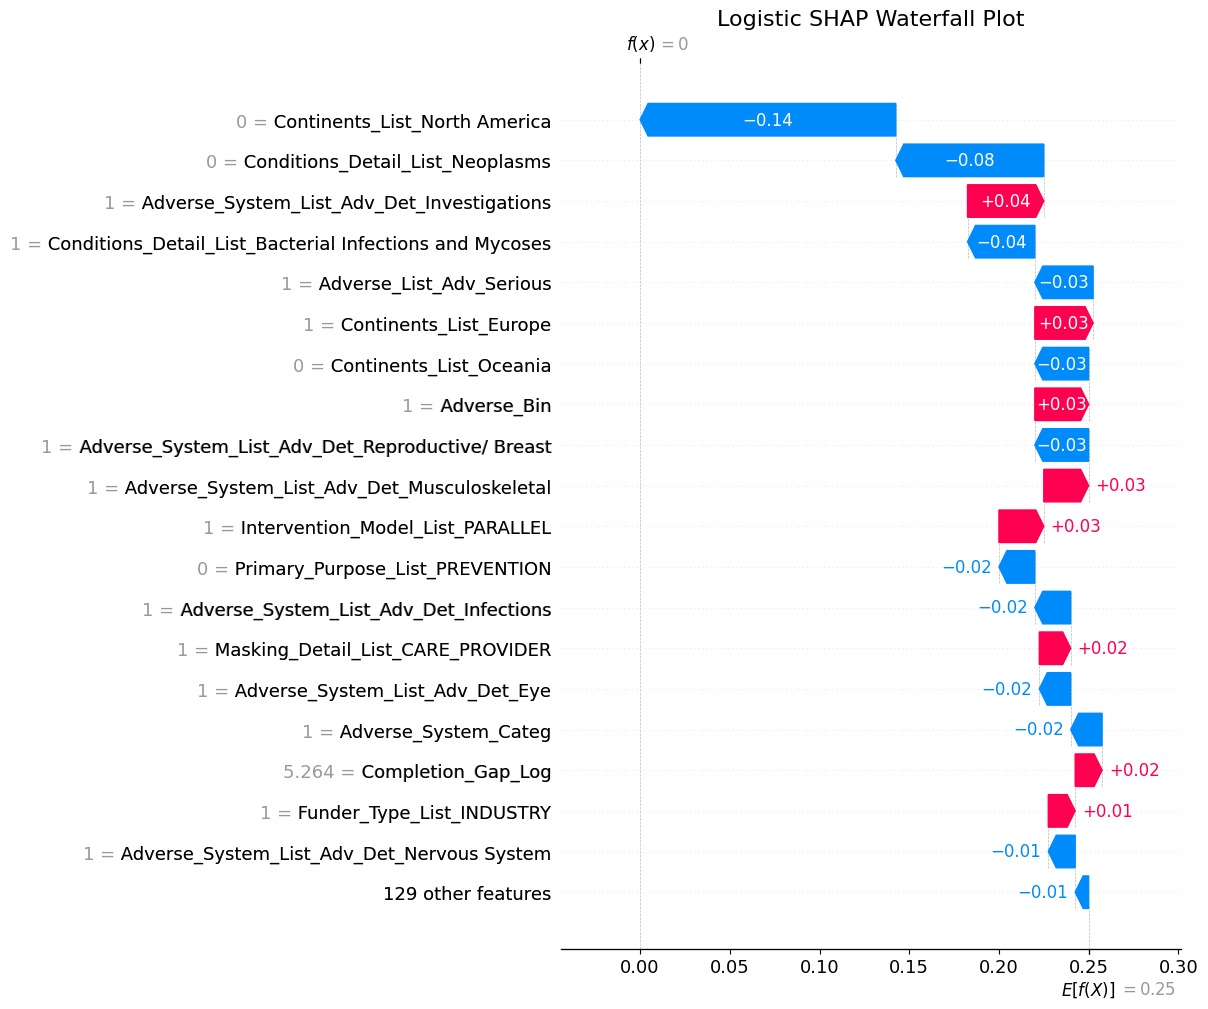

In [431]:
# Impact on the prediction (how much a feature contributes to pushing the prediction left (negative) or right (positive)).
# Blue = low feature value.
# Red = high feature value.
# Example: Enrollment_Counts_Log:
# High values (red) → strong negative SHAP values → push prediction to Completed.
# Low values (blue) → positive SHAP values → push toward Terminated.
# SHAP X-axis shows how much each feature pushes the prediction toward class 0 or 1, in log-odds space. (value -5)

# SHAP dataset overview
X_test_log_sam = shap.sample(X_test_log, 100)
explainer = shap.Explainer(log_model.predict, X_test_log_sam)
shap_values = explainer(X_test_log_sam)

# Summary Plot --> overall 
model = 'log_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

shap.summary_plot(shap_values, X_test_log_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Logistic  - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Waterfall Plot --> 1 data point prediction
shap.waterfall_plot(shap_values[0], max_display = 20, show = False) 
plt.title("Logistic SHAP Waterfall Plot", fontsize = 16) 

# Show Plot
plt.show()


### LDA - Linear Discriminant Analysis

- QDA and LDA assume Gaussian distributions.

In [361]:
# Same as log above
X_train_lda = X_train.copy()
X_test_lda = X_test.copy()
y_train_lda = y_train.copy()
y_test_lda = y_test.copy()

display(X_train_lda.shape[1])


146

Best Parameters : {'n_components': 1, 'shrinkage': 0.5556}
Best Estimator : LinearDiscriminantAnalysis(n_components=1, shrinkage=0.5556, solver='lsqr',
                           store_covariance=True)
Model : Phase 3 - Linear Discriminant Analysis (LDA)

a).
Accuracy Score : (True P + True N) / N total :
70.64%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.71      0.81      1706
           1       0.27      0.71      0.39       259

    accuracy                           0.71      1965
   macro avg       0.60      0.71      0.60      1965
weighted avg       0.85      0.71      0.75      1965


).
Matthews Correlation Coefficient (MCC) :
0.29320790298732563

c).
Plots :
ROC AUC : 0.78
PR AUC : 0.46


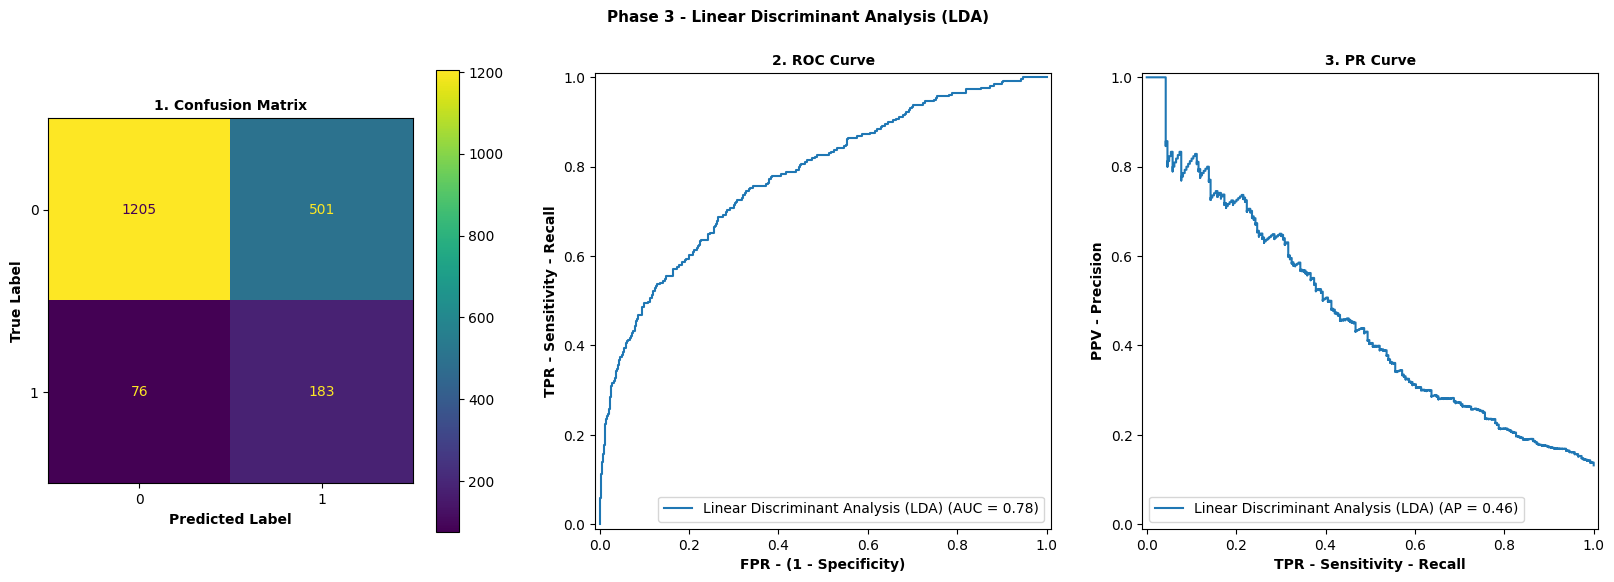

In [404]:
# Model
lda = LDA(store_covariance = True, solver = 'lsqr') # Use solver = lsqr if cv needed.

# Grid Search CV
param_grid = {
    "shrinkage" : [None, "auto"] + list(np.linspace(0.0001, 1.0, 10)), 
    'n_components' : np.arange(1, min(X_train_lda.shape[1], len(np.unique(y_train)) - 1) + 1)
    } 
lda_grid = GridSearchCV(lda, param_grid = param_grid, cv = 5, n_jobs = -1) # cv = 5 default

# Final Model
lda_model = lda_grid.fit(X_train_lda, y_train_lda) # automatically gives the best.estimator
print(f'Best Parameters : {lda_model.best_params_}')
print(f'Best Estimator : {lda_model.best_estimator_}')

# y_pred
y_pred_lda = lda_model.predict(X_test_lda)

# Accuracy Score
accuracy(dfi, i, lda_model, X_test_lda, y_test_lda, y_pred_lda, "Linear Discriminant Analysis (LDA)")


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_39440\1429119517.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_lda_sam, plot_size = (10, 5), show = False)


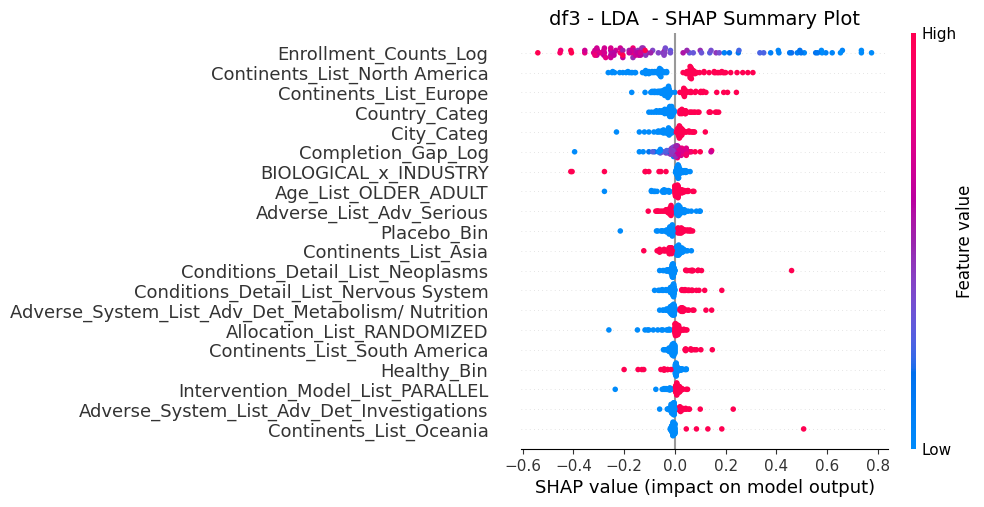

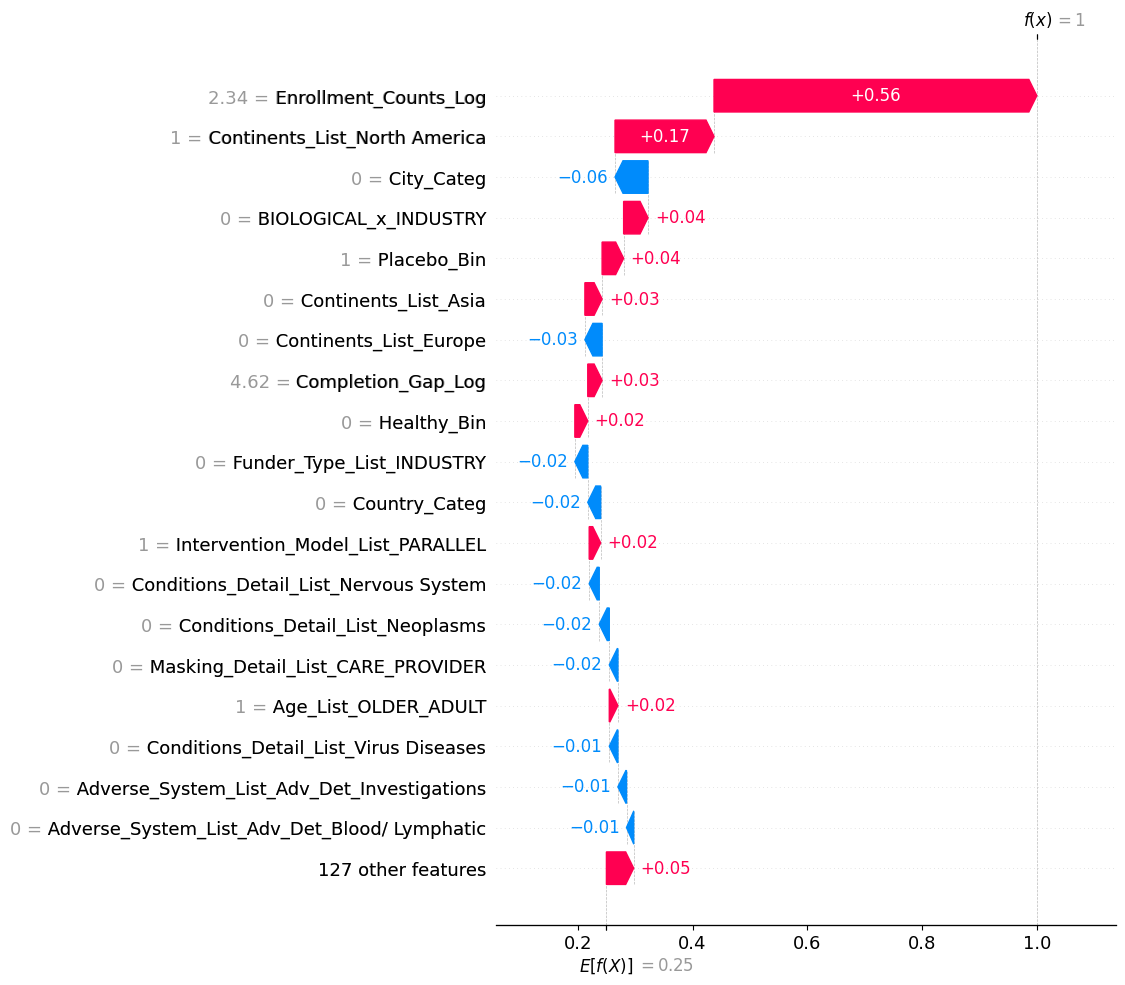

In [405]:
# SHAP
X_test_lda_sam = shap.sample(X_test_lda, 100)
explainer = shap.Explainer(lda_model.best_estimator_.predict, X_test_lda_sam)
shap_values = explainer(X_test_lda_sam)

# Save plot
model = 'lda_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_lda_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - LDA  - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)


### QDA - Quantratic Discriminant Analysis
- QDA very sensistive to collinear data!
QDA and LDA assume Gaussian distributions.

In [ ]:
# QDA does not assume linear relation X - y --> lasso assumes. 
# However lasso before QDA gives better results. (in auc and also accuracy)

X_train_qda = X_train.copy()
X_test_qda = X_test.copy()
y_train_qda = y_train.copy()
y_test_qda = y_test.copy()

display(X_train_qda.shape[1])

38

"Best Parameters : {'reg_param': 1.0}"

'Best Estimator : QuadraticDiscriminantAnalysis(reg_param=1.0, store_covariance=True)'

Model : Phase 3 - Quantric Discriminant Analysis (QDA)

a).
Accuracy Score : (True P + True N) / N total :
74.19%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.74      0.83      2150
           1       0.28      0.77      0.42       291

    accuracy                           0.74      2441
   macro avg       0.62      0.75      0.62      2441
weighted avg       0.88      0.74      0.78      2441


).
Matthews Correlation Coefficient (MCC) :
0.35211777638437897

c).
Plots :
ROC AUC : 0.83
PR AUC : 0.55


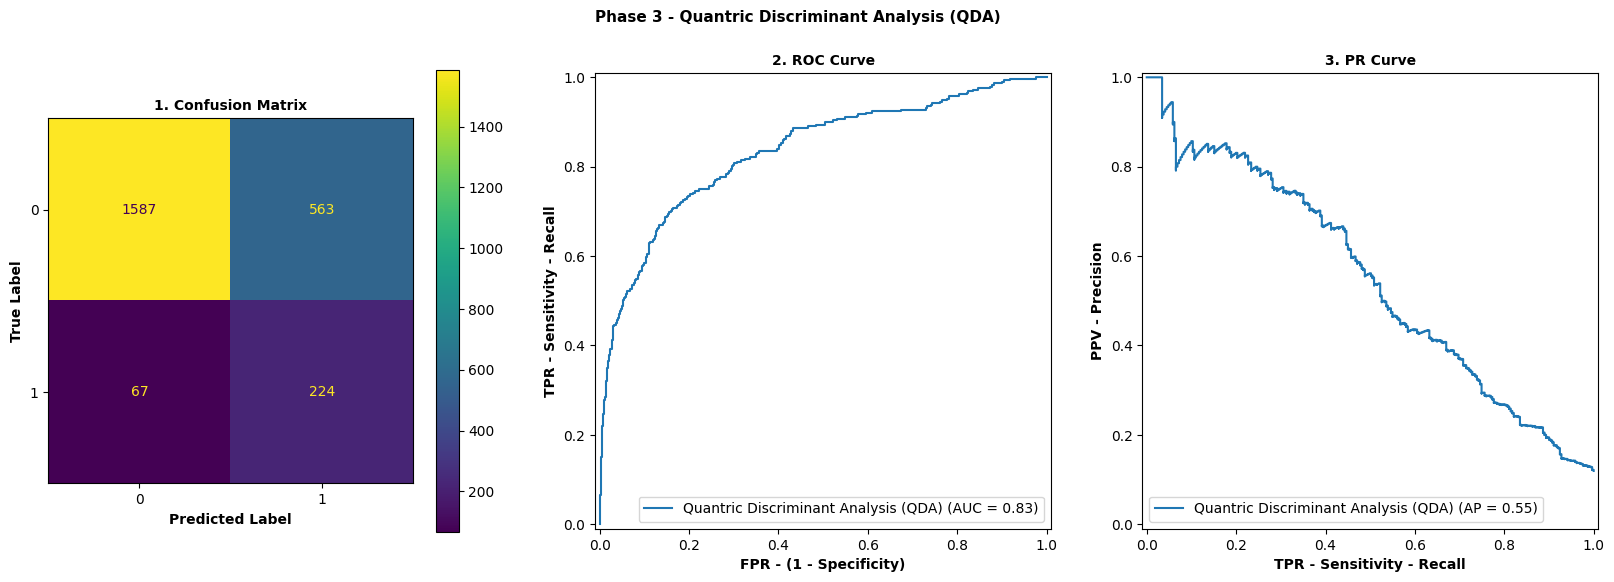

In [377]:
# Model
qda = QDA(store_covariance = True)

# GridSearch
param_grid = {
    "reg_param": np.linspace(0, 1, 30)
    }
qda_grid = GridSearchCV(qda, param_grid = param_grid, cv = 5, n_jobs = -1) # cv = 5 default

# Final model
qda_model = qda_grid.fit(X_train_qda, y_train_qda)
display(f'Best Parameters : {qda_model.best_params_}')
display(f'Best Estimator : {qda_model.best_estimator_}')

# y_pred
y_pred_qda = qda_model.predict(X_test_qda)

# Accuracy Score
accuracy(dfi, i, qda_model, X_test_qda, y_test_qda, y_pred_qda, "Quantric Discriminant Analysis (QDA)")

C:\Users\Eugenia\AppData\Local\Temp\ipykernel_39440\1307359302.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_qda_sam, plot_size = (10, 5), show = False)


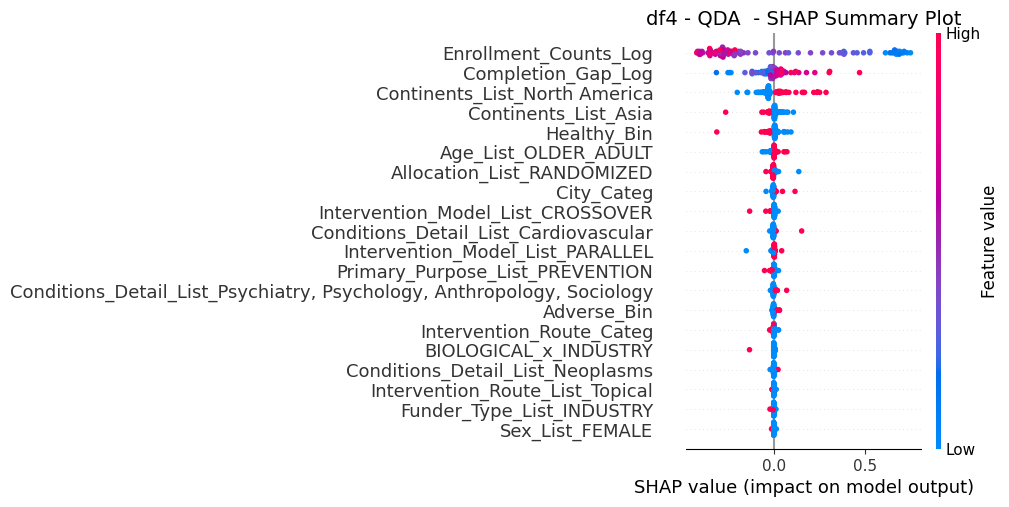

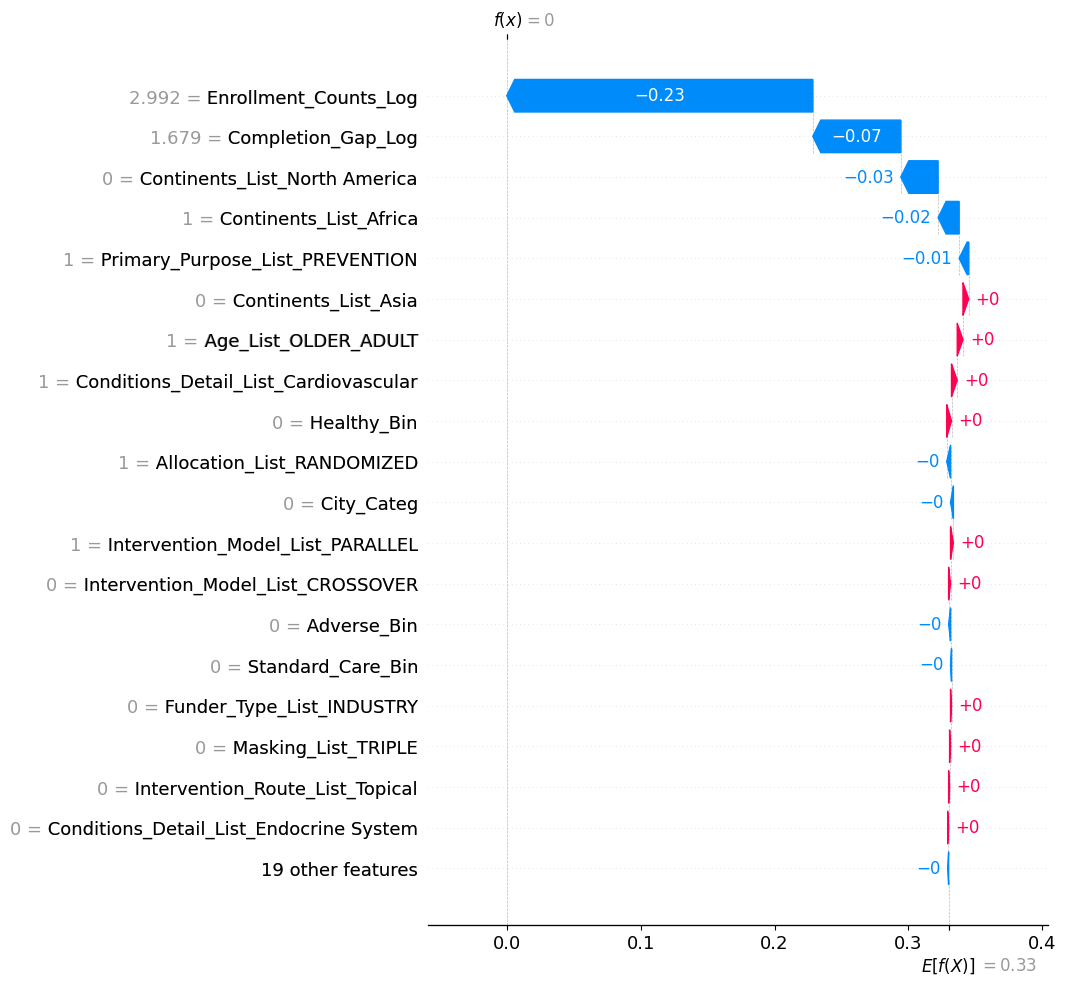

In [200]:
# SHAP
X_test_qda_sam = shap.sample(X_test_qda, 100)
explainer = shap.Explainer(qda_model.best_estimator_.predict, X_test_qda_sam)
shap_values = explainer(X_test_qda_sam)

# Save plot
model = 'qda_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_qda_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - QDA  - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### Elastic Net Logistic Regression
- l1_ratio l1 / l2 = Elastic Net
- l1_ratio = 1 = Lasso (l1)
- l1_ratio = 0 = Ridge (l2) 
- 0 < l1_ratio < 1 

In [201]:
X_train_el = X_train.copy() 
X_test_el = X_test.copy()
y_train_el = y_train.copy()
y_test_el = y_test.copy()

display(X_train_el.shape[1])


146

"Best Parameters : {'l1_ratio': 1.0}"

"Best Estimator : LogisticRegression(l1_ratio=1.0, max_iter=3000, penalty='elasticnet',\n                   random_state=42, solver='saga')"

Model : Phase 4 - Elastic Net Logistic Regression

a).
Accuracy Score : (True P + True N) / N total :
77.02%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.77      0.85      2150
           1       0.32      0.79      0.45       291

    accuracy                           0.77      2441
   macro avg       0.64      0.78      0.65      2441
weighted avg       0.89      0.77      0.81      2441


).
Matthews Correlation Coefficient (MCC) :
0.39658869014093084

c).
Plots :
ROC AUC : 0.86
PR AUC : 0.58


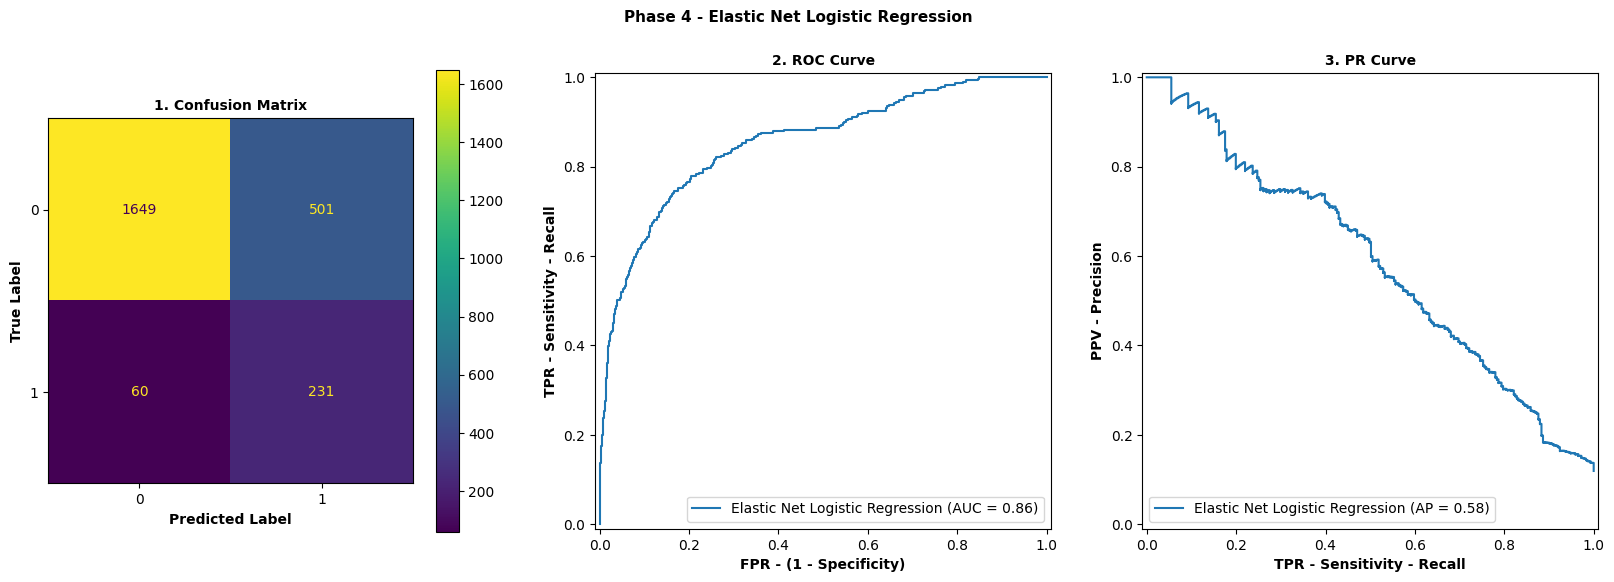

In [202]:
# Model (4+min df5)
log_el = LogisticRegression(penalty = 'elasticnet', max_iter = 3000, solver = "saga", random_state = 42)   

# Grid Search
param_grid = {
    "l1_ratio" : np.linspace(0.1, 1, 10, endpoint = True)
    } 
log_el_grid = GridSearchCV(log_el, param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
el_model = log_el_grid.fit(X_train_el, y_train_el)  
display(f'Best Parameters : {el_model.best_params_}')
display(f'Best Estimator : {el_model.best_estimator_}')

# y_pred
y_pred_el = el_model.predict(X_test_el)

# Accuracy Score
accuracy(dfi, i, el_model, X_test_el, y_test_el, y_pred_el, "Elastic Net Logistic Regression")


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_39440\2177796025.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_el_sam, plot_size = (10, 5), show = False)


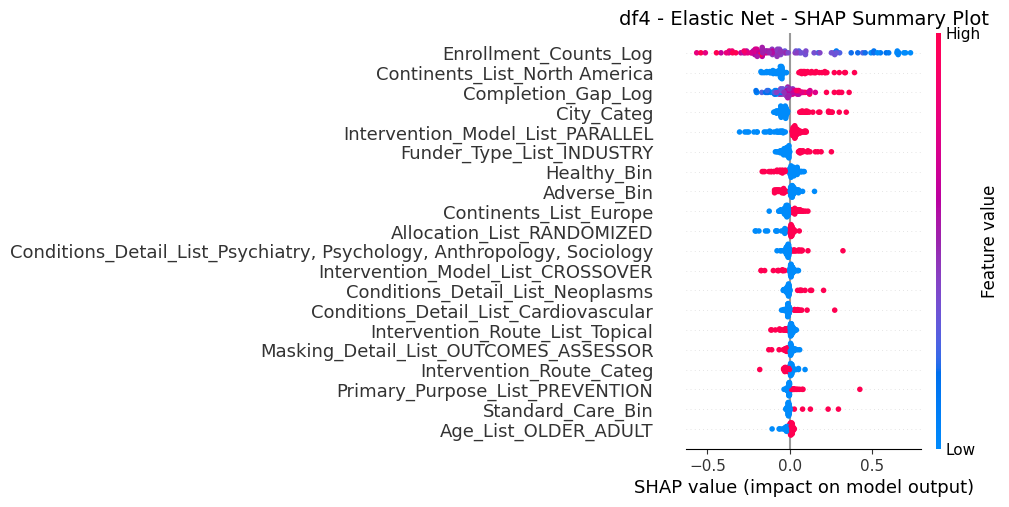

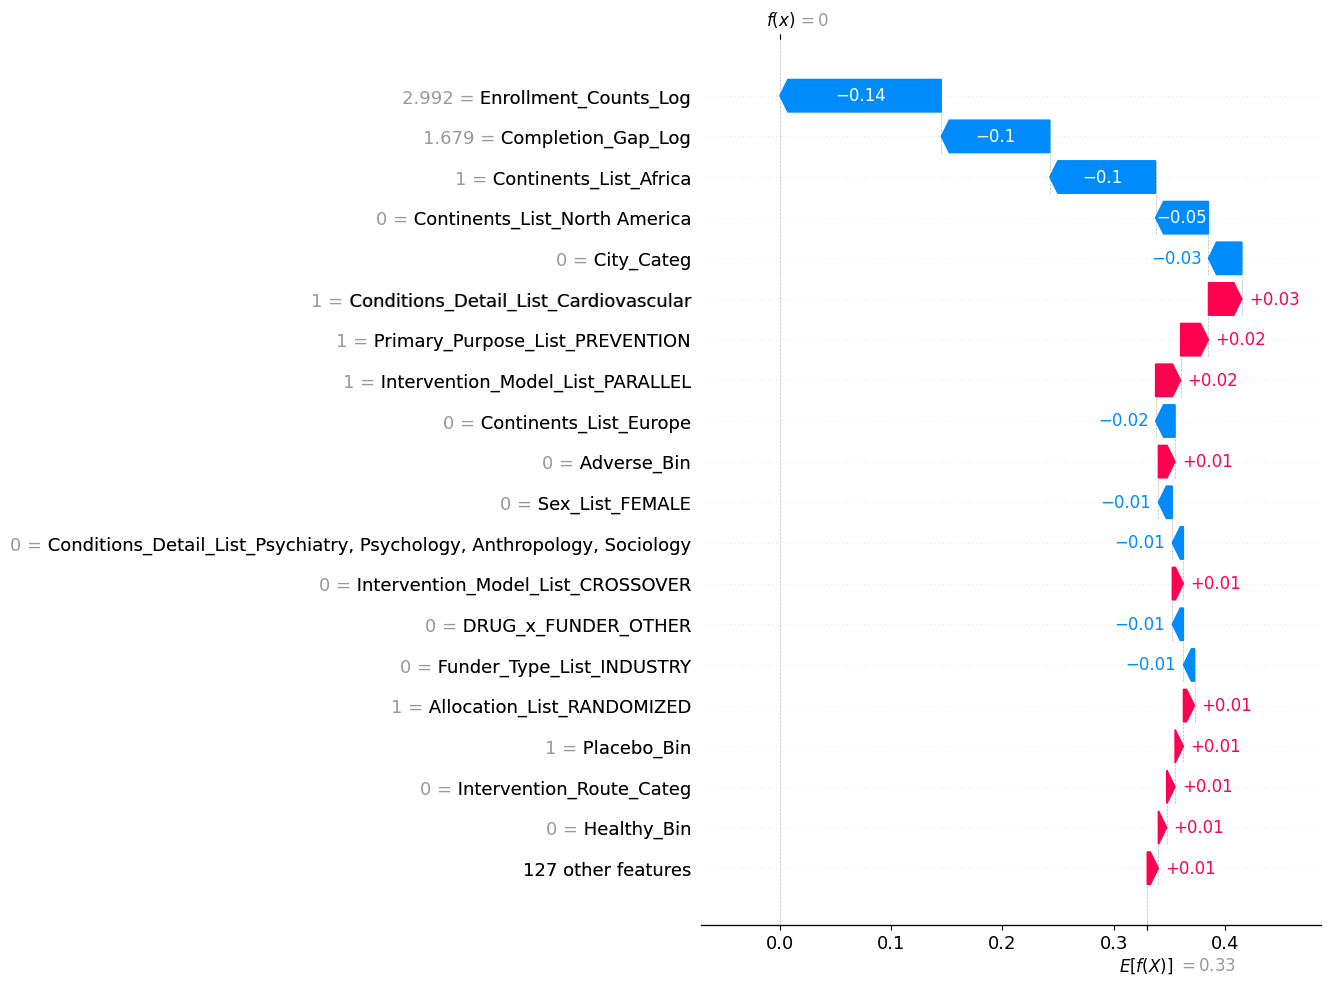

In [203]:
# SHAP
X_test_el_sam = shap.sample(X_test_el, 100)
explainer = shap.Explainer(el_model.best_estimator_.predict, X_test_el_sam)
shap_values = explainer(X_test_el_sam)

# Save plot
model = 'el_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_el_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Elastic Net - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

## B) ML Classification

### KNN - K Nearest Neighbors

In [204]:
# KNN --> Dimension reduction did not impact the scores. (Distances matter more than dimension in knn)
X_train_knn = X_train.copy()
X_test_knn = X_test.copy()
y_train_knn = y_train.copy()
y_test_knn = y_test.copy()

display(X_train_knn.shape[1])

146

"Best Parameters : {'n_neighbors': 91}"

'Best Estimator : KNeighborsClassifier(n_neighbors=91)'

Model : Phase 4 - K-Nearest Neighbors Classifier (KNN)

a).
Accuracy Score : (True P + True N) / N total :
73.99%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      2150
           1       0.28      0.78      0.42       291

    accuracy                           0.74      2441
   macro avg       0.62      0.76      0.62      2441
weighted avg       0.88      0.74      0.78      2441


).
Matthews Correlation Coefficient (MCC) :
0.3554022589193893

c).
Plots :
ROC AUC : 0.84
PR AUC : 0.58


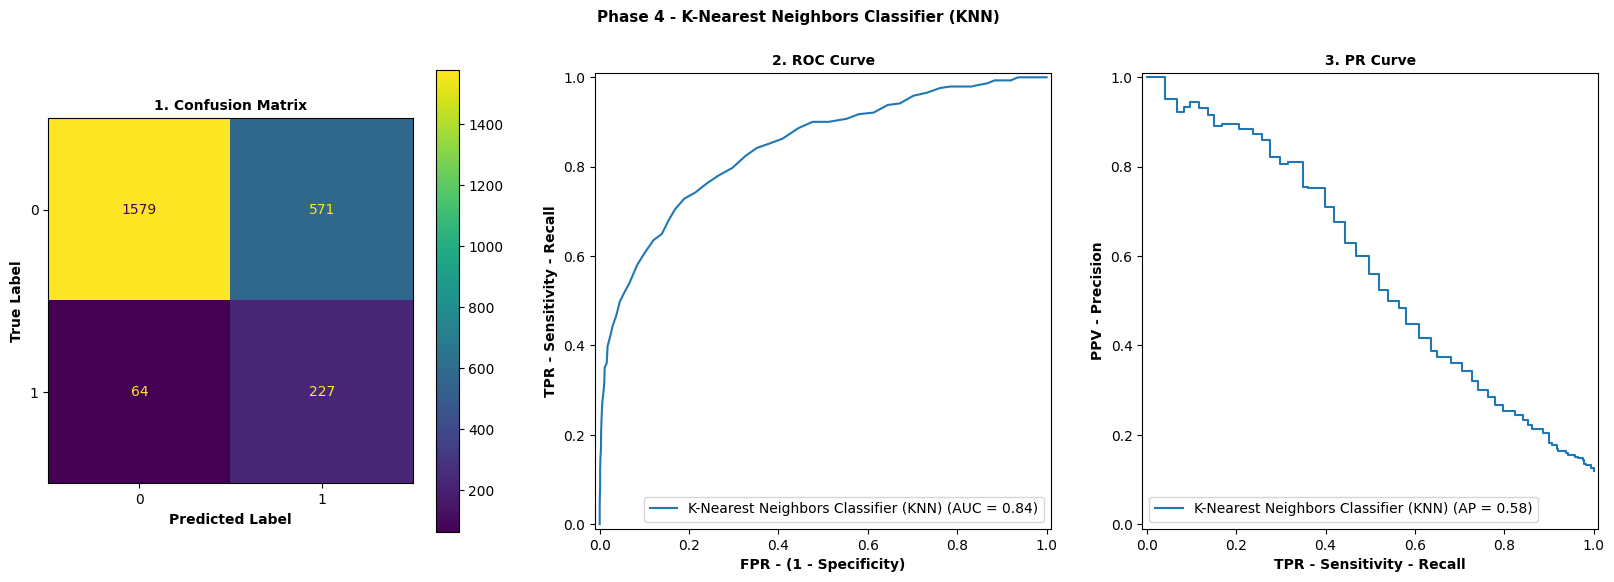

In [205]:
# Model (2+ min)
knn = KNeighborsClassifier()

# Grid Search
param_grid = {"n_neighbors" : np.linspace(1, 100, 50, endpoint = True).astype(int)} 

# CV
knn_grid = GridSearchCV(knn , param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
knn_model = knn_grid.fit(X_train_knn, y_train_knn)
display(f'Best Parameters : {knn_model.best_params_}')
display(f'Best Estimator : {knn_model.best_estimator_}')

# y_pred
y_pred_knn = knn_model.predict(X_test_knn)

# Accuracy Score
accuracy(dfi, i, knn_model, X_test_knn, y_test_knn, y_pred_knn, "K-Nearest Neighbors Classifier (KNN)")


PermutationExplainer explainer: 101it [01:22,  1.08it/s]                         
C:\Users\Eugenia\AppData\Local\Temp\ipykernel_39440\4002721857.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_knn_sam, plot_size = (10, 5), show = False)


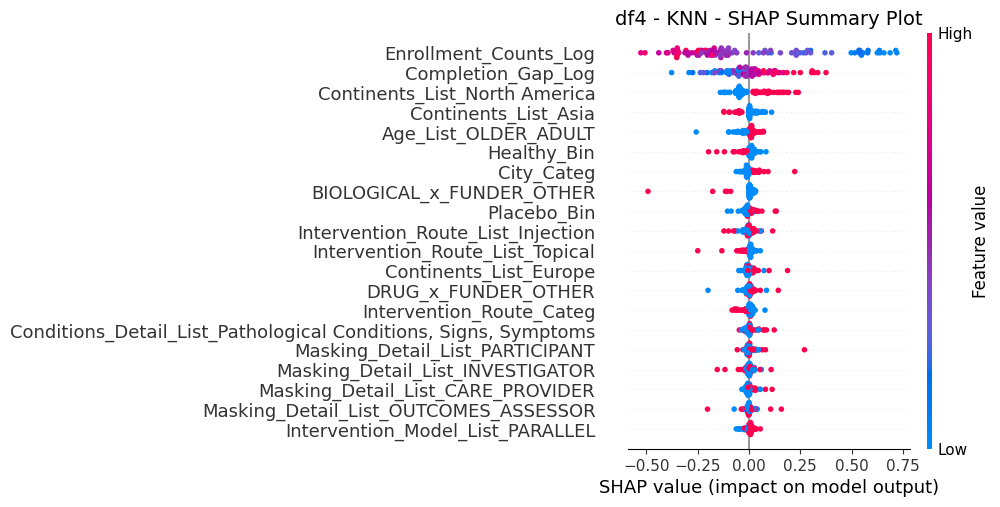

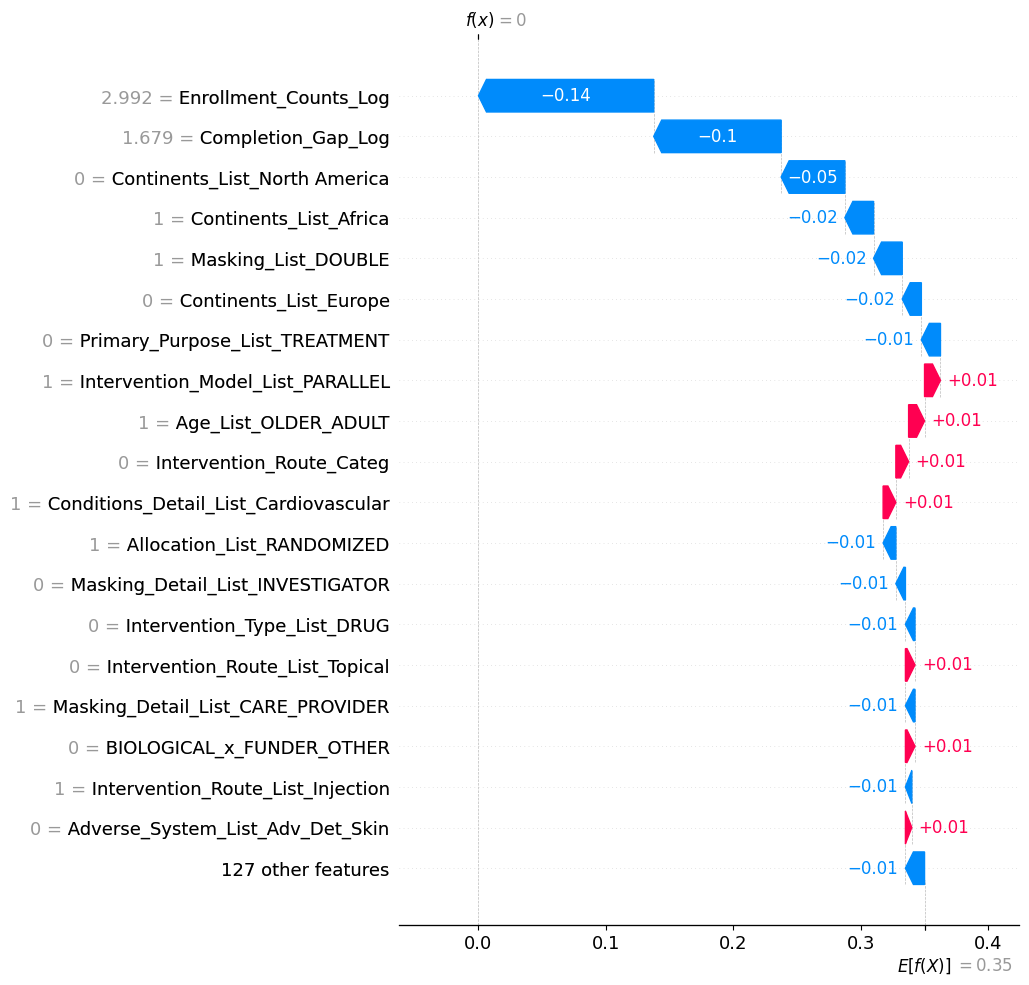

In [206]:
# SHAP
X_test_knn_sam = shap.sample(X_test_knn, 100)  # sample needed for computational efficacy
explainer = shap.Explainer(knn_model.best_estimator_.predict, X_test_knn_sam)
shap_values = explainer(X_test_knn_sam)

# Save plot
model = 'knn_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_knn_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - KNN - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### SVC - Support Vector Classifier
- (31+mins + lasso df)

In [207]:
# SVC --> Dimension reduction did not impact scores (+ impacted a little negative)

X_train_svc = X_train.copy()
X_test_svc = X_test.copy()
y_train_svc = y_train.copy()
y_test_svc = y_test.copy()

display(X_train_svc.shape[1])

146

"Best Parameter kernel: {'degree': 2, 'kernel': 'poly'}"

"Best Estimator: SVC(class_weight='balanced', degree=2, kernel='poly', probability=True,\n    random_state=42)"

Model : Phase 4 - Support Vector Classifier (SVC)

a).
Accuracy Score : (True P + True N) / N total :
77.71%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      2150
           1       0.32      0.77      0.45       291

    accuracy                           0.78      2441
   macro avg       0.64      0.78      0.66      2441
weighted avg       0.89      0.78      0.81      2441


).
Matthews Correlation Coefficient (MCC) :
0.39419628767225684

c).
Plots :
ROC AUC : 0.85
PR AUC : 0.56


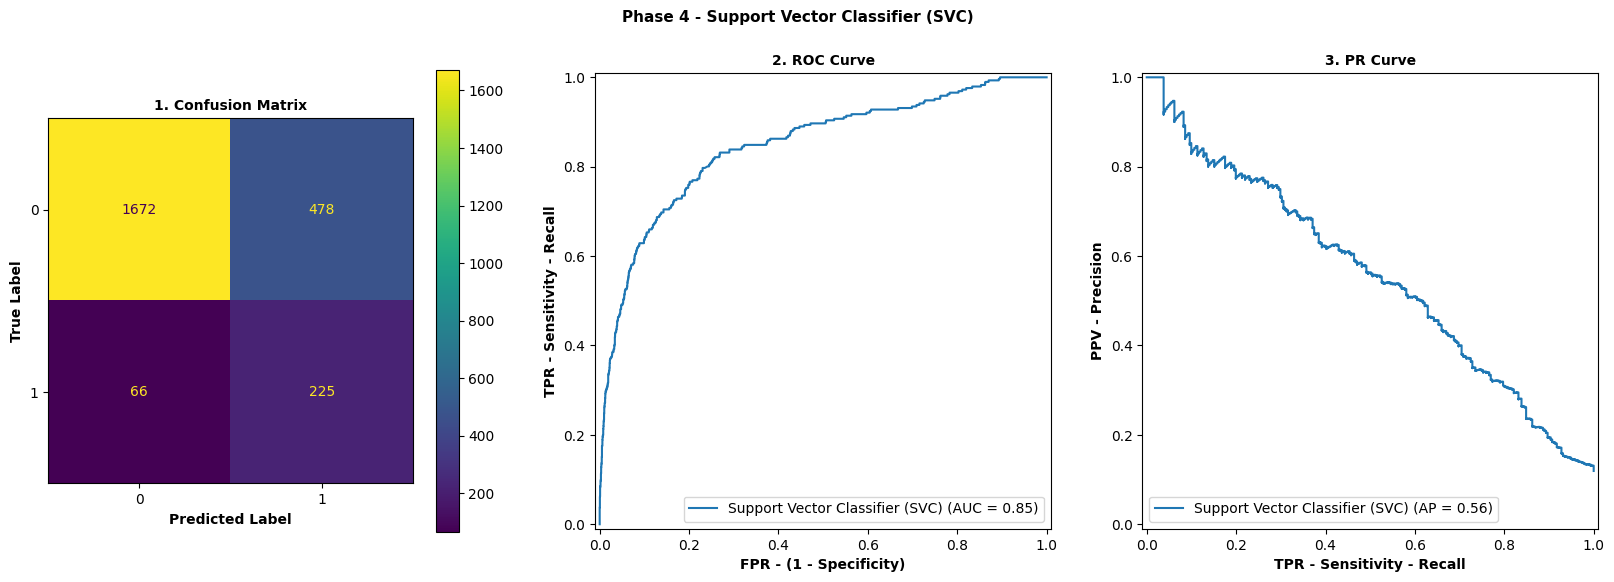

In [ ]:
# Model (max = 7.5 mins df5)   
svc = SVC(probability = True, random_state = 42, class_weight = 'balanced')

# Hyperparameters CV
param_grid = [
    {"C": [0.1, 1, 10, 100]},
    {"kernel": ["linear"]},
    {"kernel": ["rbf"]},
    {"kernel": ["sigmoid"]},
    {"kernel": ["poly"], "degree": [2, 3]}  # df --> chooses 'rdf' --> maybe exclude poly cause it runs too slow 31+min.
]

# CV
svc_grid = GridSearchCV(svc, param_grid = param_grid, cv = 5, n_jobs = -1) # 4 cv cause it runs too slow with 5.

# Final Model
svc_model = svc_grid.fit(X_train_svc, y_train_svc)
display(f'Best Parameter kernel: {svc_model.best_params_}')
display(f'Best Estimator: {svc_model.best_estimator_}')

# y_pred
y_pred_svc = svc_model.predict(X_test_svc)

# Accuracy Score
accuracy(dfi, i, svc_model, X_test_svc, y_test_svc, y_pred_svc, "Support Vector Classifier (SVC)")


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_39440\3536509692.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_svc_sam, plot_size = (10, 5), show = False)


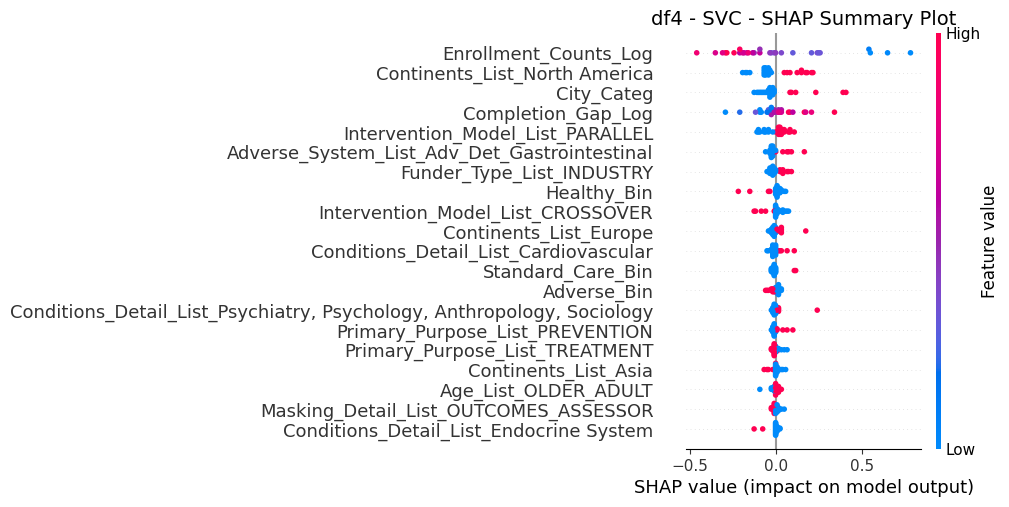

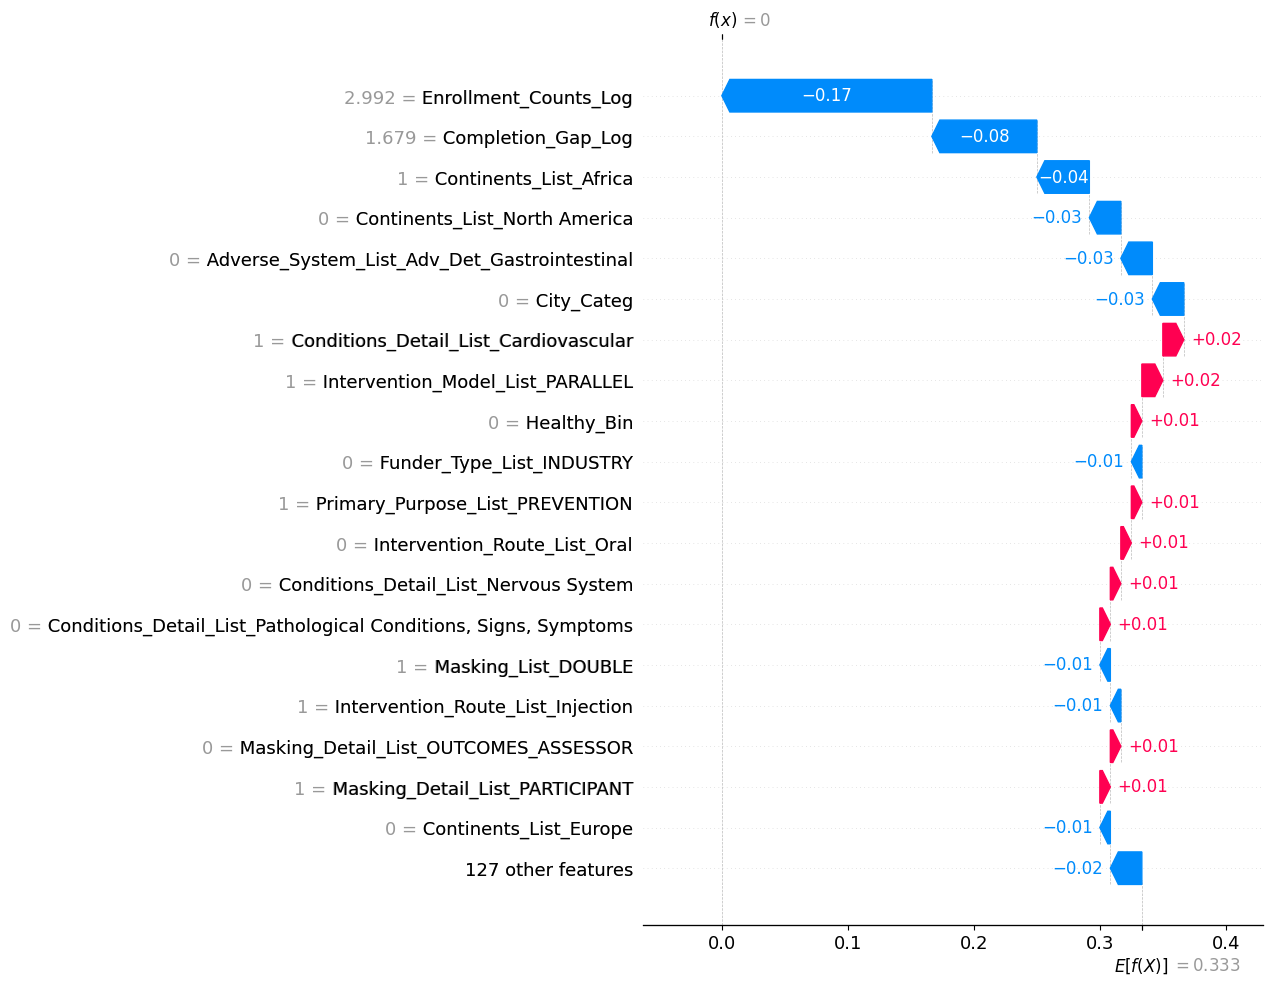

In [209]:
# SHAP (5+ mins maybe)
X_test_svc_sam = shap.sample(X_test_svc, 30)  # 30 cause computationaly too slow 
explainer = shap.Explainer(svc_model.best_estimator_.predict, X_test_svc_sam)
shap_values = explainer(X_test_svc_sam)

# Save plot
model = 'svc_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_svc_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - SVC - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### Tree (Pruned)


In [210]:
# Built-in Feature Selective models
X_train_tr = X_train.copy()
X_test_tr = X_test.copy()
y_train_tr = y_train.copy()
y_test_tr = y_test.copy()

display(X_train_tr.shape[1])

146

In [211]:
# cc_alphas values meaningful for dataset
tree = DecisionTreeClassifier(random_state = 42)
path = tree.cost_complexity_pruning_path(X_train_tr, y_train_tr)
ccp_alphas = path.ccp_alphas
display(ccp_alphas.min(), ccp_alphas.mean(), ccp_alphas.max())

0.0

0.0015854906403488375

0.12206284905375614

"Best Parameter criterion/max_depth: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}"

"Best Estimator : DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,\n                       random_state=42)"

Model : Phase 4 - Decision Tree Classifier

a).
Accuracy Score : (True P + True N) / N total :
78.29%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.79      0.87      2150
           1       0.32      0.71      0.44       291

    accuracy                           0.78      2441
   macro avg       0.63      0.75      0.65      2441
weighted avg       0.88      0.78      0.81      2441


).
Matthews Correlation Coefficient (MCC) :
0.36704827435011517

c).
Plots :
ROC AUC : 0.82
PR AUC : 0.46


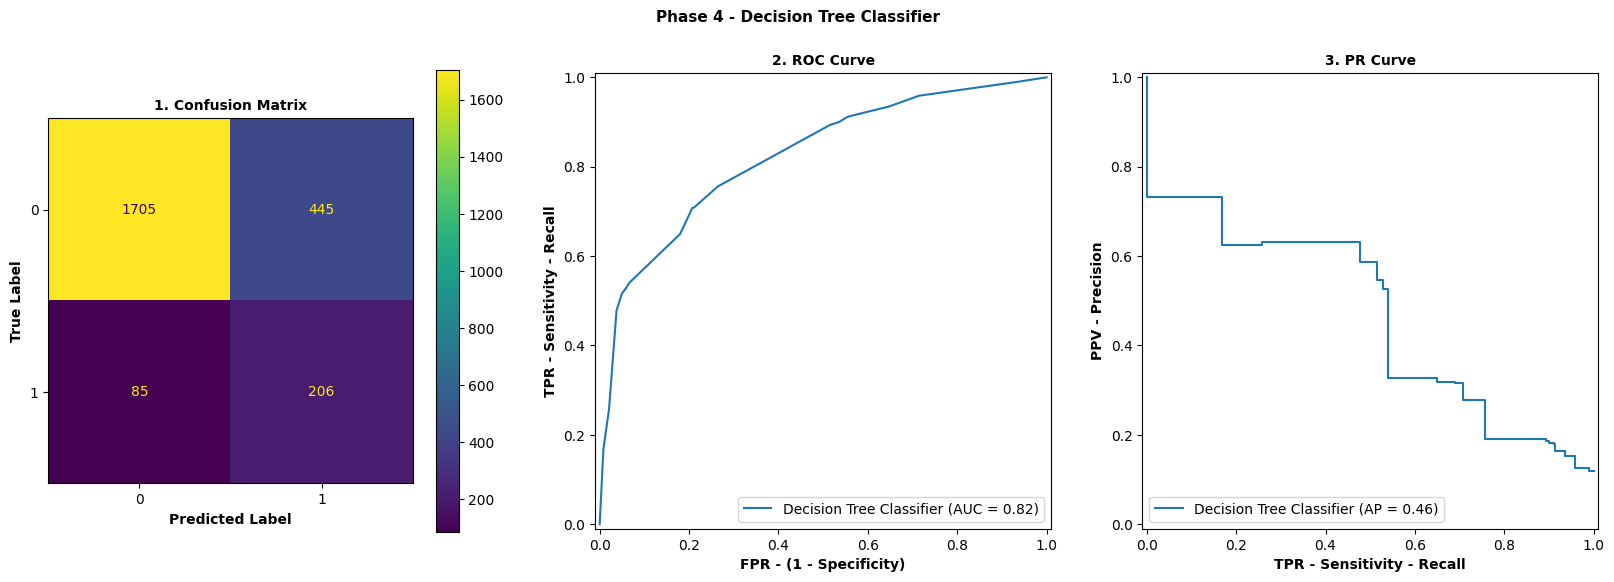

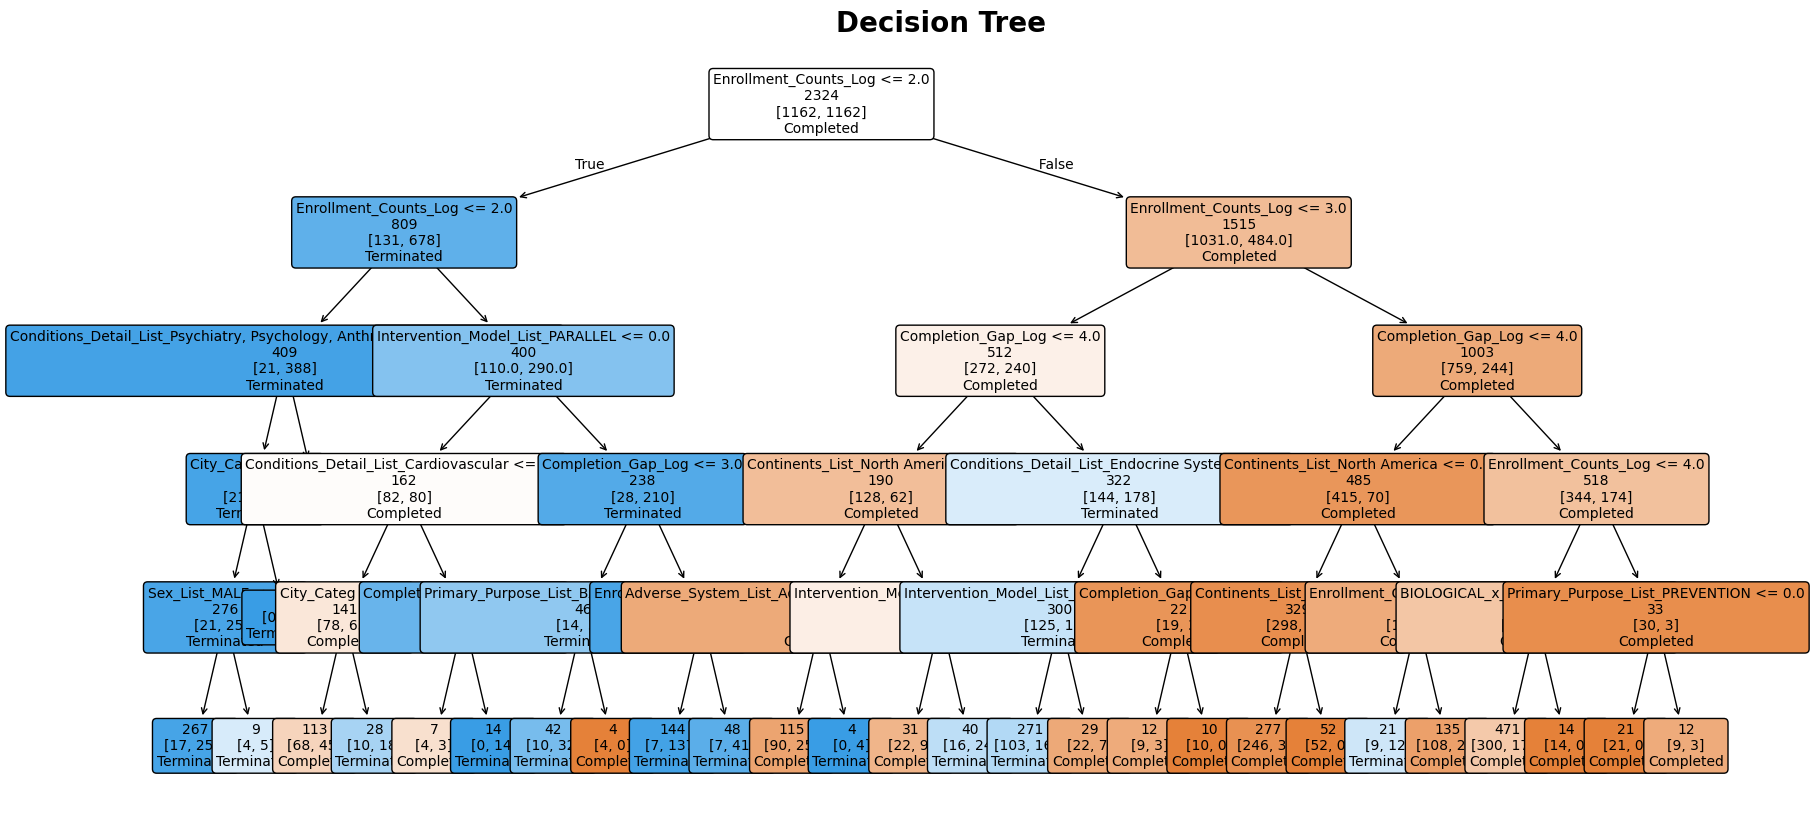

In [212]:
# Model (3+ mins df5)
tree = DecisionTreeClassifier(random_state = 42)

# Hyperparameters CV
param_grid = {
    'criterion': ['gini', 'entropy'],           # Splitting strategy
    'max_depth': [2, 3, 5, 10, 20, None],       # give small depth as choice # Pre-pruning --> Built in feature Selection
    'min_samples_split': [2, 5, 10],            # Min samples to split a node
    'min_samples_leaf': [1, 2, 4],              # Min samples in a leaf
    'max_features': [None, 'sqrt', 'log2'],     # Max features to consider at each split
    'ccp_alpha': np.linspace(0, np.max(ccp_alphas), 10),   # Post-Pruning --> Cost-complexity parameter
}

# CV
tree_grid = GridSearchCV(tree, param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
tr_model = tree_grid.fit(X_train_tr, y_train_tr)
display(f'Best Parameter criterion/max_depth: {tr_model.best_params_}')
display(f'Best Estimator : {tr_model.best_estimator_}')

# y_pred
y_pred_tr = tr_model.predict(X_test_tr)

# Accuracy Score
accuracy(dfi, i, tr_model, X_test_tr, y_test_tr, y_pred_tr, "Decision Tree Classifier")

# Plot Tree
tree_clf = tr_model.best_estimator_

plt.figure(figsize = (20, 10))
plot_tree(
    tree_clf,
    feature_names = X_train_tr.columns,
    class_names = ['Completed', 'Terminated'],
    max_depth = tr_model.best_params_['max_depth'],
    label = 'none',
    filled = True,
    rounded = True,
    proportion = False,
    impurity = False,
    precision = 0,
    fontsize = 10
)
plt.title("Decision Tree", fontsize = 20, fontweight = 'bold')
plt.show()


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_39440\3219855117.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_tr_sam, plot_size = (10, 5), show = False)


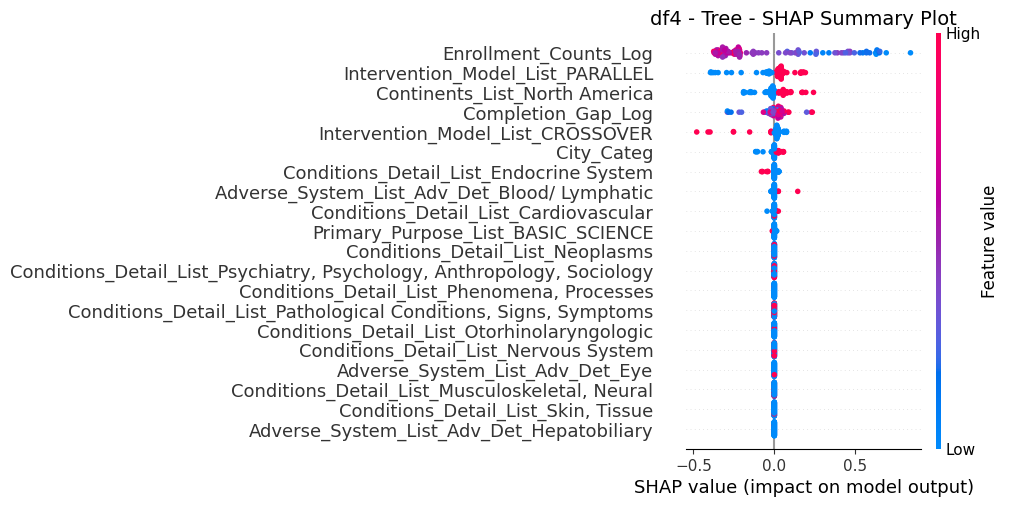

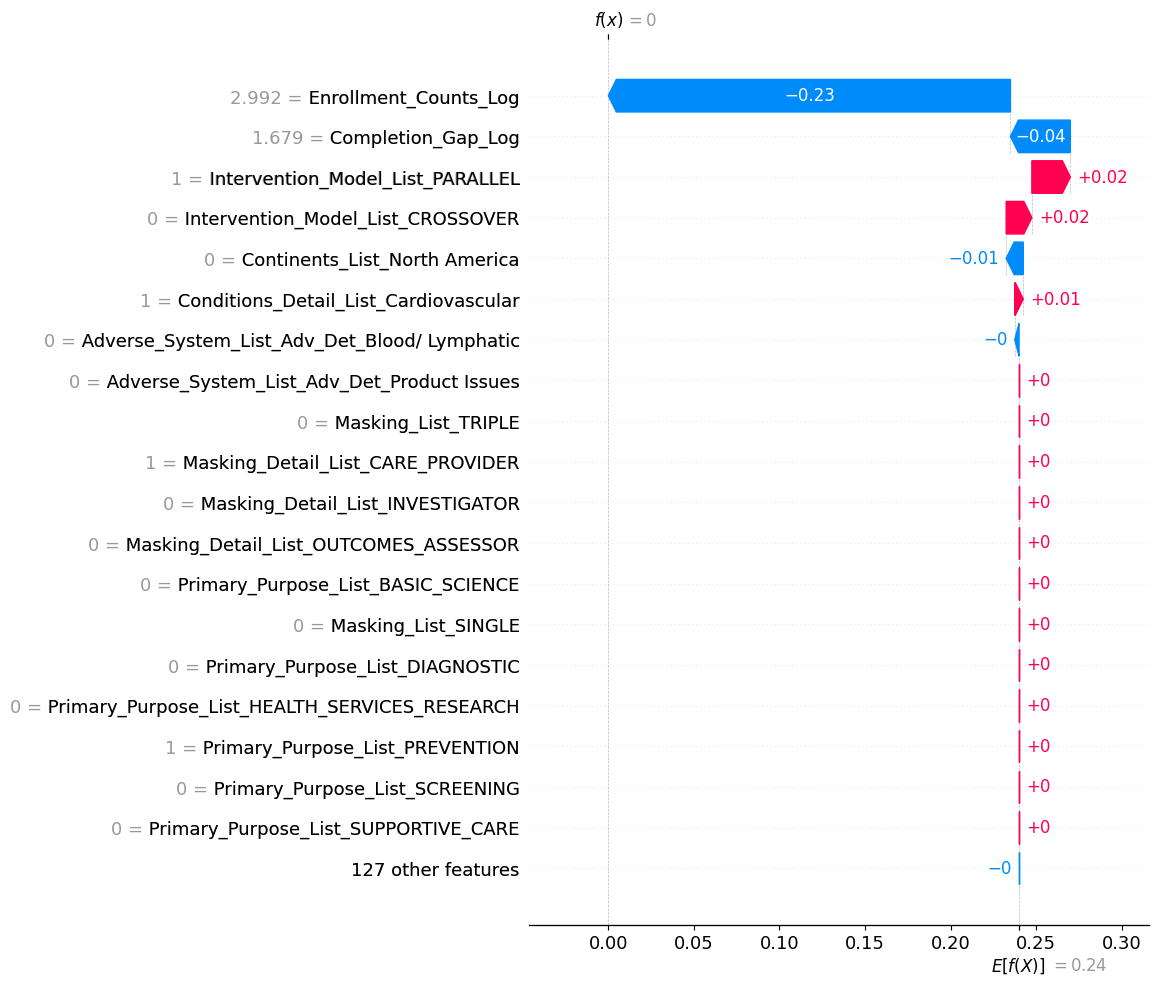

In [213]:
# SHAP
X_test_tr_sam = shap.sample(X_test_tr, 100)
explainer = shap.Explainer(tr_model.best_estimator_.predict, X_test_tr_sam)
shap_values = explainer(X_test_tr_sam)

# Save plot
model = 'tr_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_tr_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Tree - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### Random Forest

In [214]:
# Built-in Feature Selective models
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()
y_train_rf = y_train.copy()
y_test_rf = y_test.copy()

display(X_train_rf.shape[1])

146

"Best Parameter criterion/bootstrap/n_estimators : {'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt'}"

'Best Estimator : RandomForestClassifier(random_state=42)'

Model : Phase 4 - Random Forest Classifier

a).
Accuracy Score : (True P + True N) / N total :
78.82%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.79      0.87      2150
           1       0.33      0.75      0.46       291

    accuracy                           0.79      2441
   macro avg       0.64      0.77      0.66      2441
weighted avg       0.88      0.79      0.82      2441


).
Matthews Correlation Coefficient (MCC) :
0.3955049911250125

c).
Plots :
ROC AUC : 0.84
PR AUC : 0.51


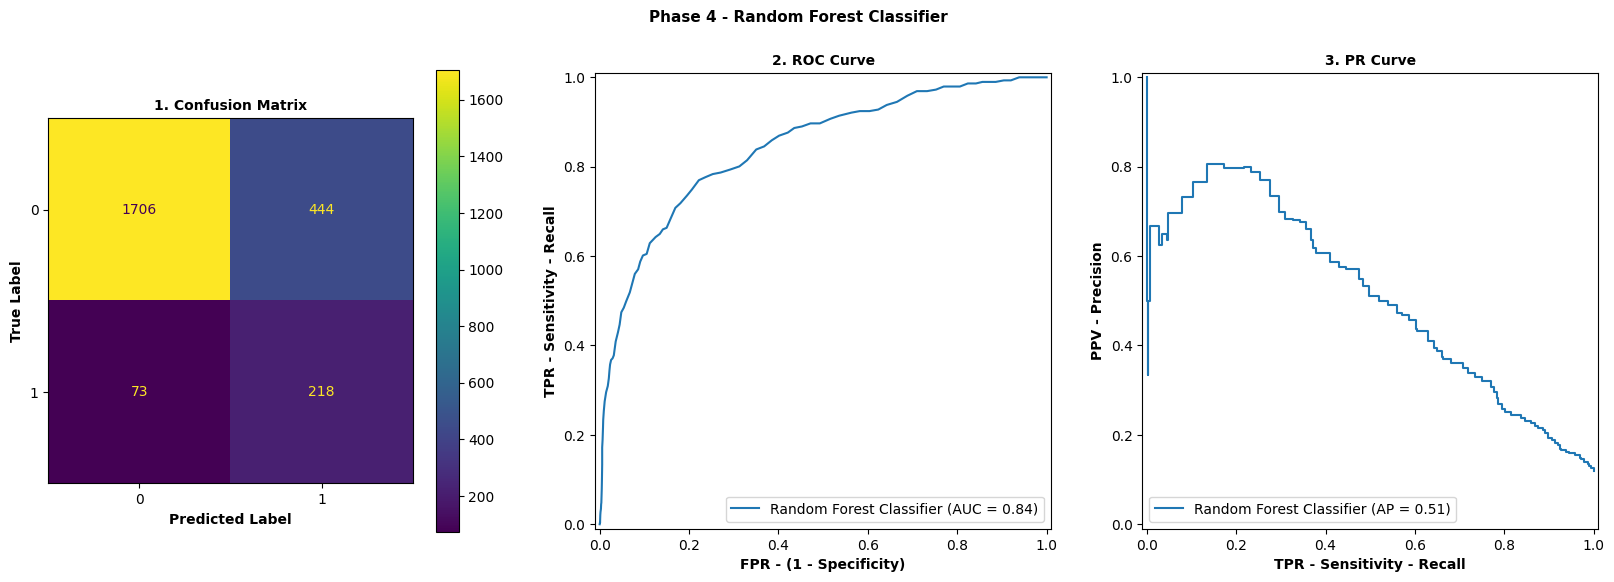

In [215]:
# Model (1+min)
forest = RandomForestClassifier(random_state = 42)

# CV
param_grid = {
    "criterion" : ['gini', 'entropy', 'log_loss'], 
    "bootstrap" : [True, False],  # Bootstrap samples when building trees. If False, the whole dataset is used to build each tree.
    "max_features" : ["sqrt", "log2", None]  # None = m = p = Bagging Random Forest. / sqrt = m = sqrt(p) = Classic Random Forest. / log2 = m = log2(p) = Other Random Forest.
    } 

forest_grid = GridSearchCV(forest , param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
rf_model = forest_grid.fit(X_train_rf, y_train_rf)
display(f'Best Parameter criterion/bootstrap/n_estimators : {rf_model.best_params_}')
display(f'Best Estimator : {rf_model.best_estimator_}')

# y_pred
y_pred_rf = rf_model.predict(X_test_rf)

# Accuracy Score
accuracy(dfi, i, rf_model, X_test_rf, y_test_rf, y_pred_rf, "Random Forest Classifier")


PermutationExplainer explainer: 101it [00:14,  2.28it/s]                         
C:\Users\Eugenia\AppData\Local\Temp\ipykernel_39440\50703949.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_rf_sam, plot_size = (10, 5), show = False)


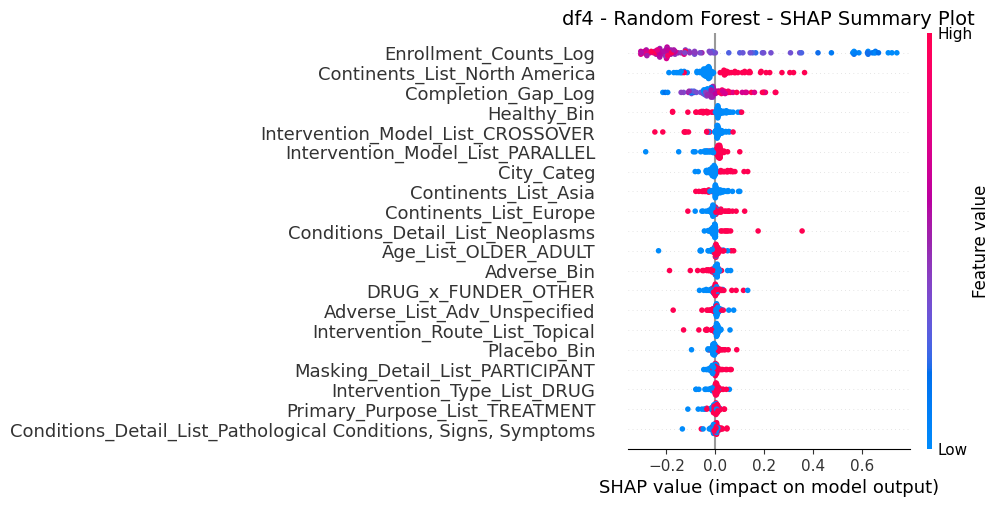

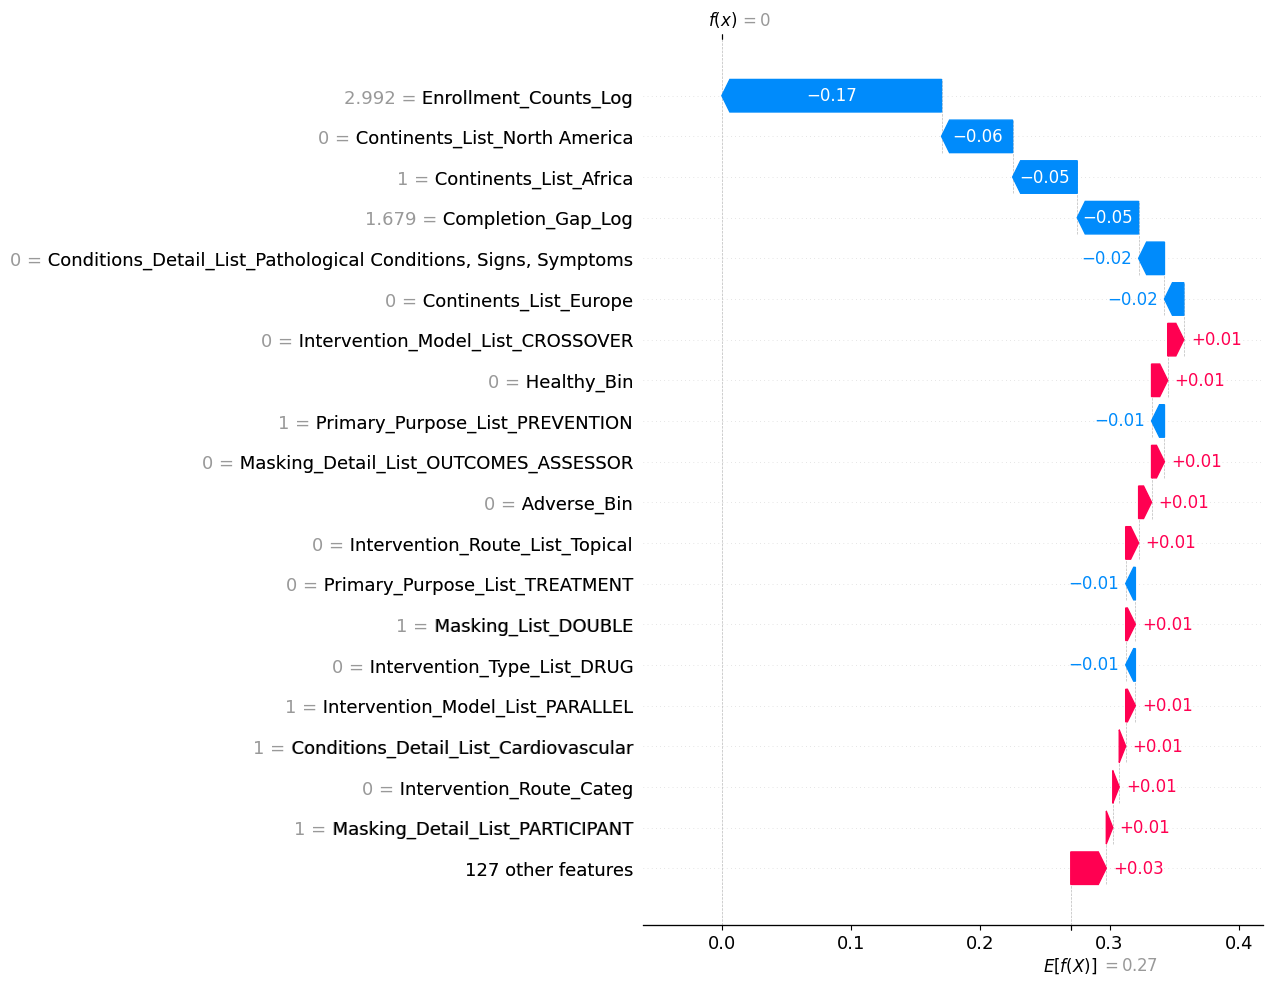

In [216]:
# SHAP
X_test_rf_sam = shap.sample(X_test_rf, 100)
explainer = shap.Explainer(rf_model.best_estimator_.predict, X_test_rf_sam)
shap_values = explainer(X_test_rf_sam)

# Save plot
model = 'rf_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_rf_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Random Forest - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### Gradient Boosting Classifier

In [217]:
# Built-in Feature Selective models
X_train_gb = X_train.copy()
X_test_gb = X_test.copy()
y_train_gb = y_train.copy()
y_test_gb = y_test.copy()

display(X_train_gb.shape[1])

146

"Best Parameter learning_rate : {'learning_rate': 0.1778888888888889, 'max_depth': 3}"

'Best Estimator : GradientBoostingClassifier(learning_rate=0.1778888888888889, random_state=42)'

Model : Phase 3 - Gradient Boosting Classifier

a).
Accuracy Score : (True P + True N) / N total :
78.53%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.79      0.87      2150
           1       0.33      0.75      0.45       291

    accuracy                           0.79      2441
   macro avg       0.64      0.77      0.66      2441
weighted avg       0.88      0.79      0.82      2441


).
Matthews Correlation Coefficient (MCC) :
0.3900466057933605

c).
Plots :
ROC AUC : 0.86
PR AUC : 0.58


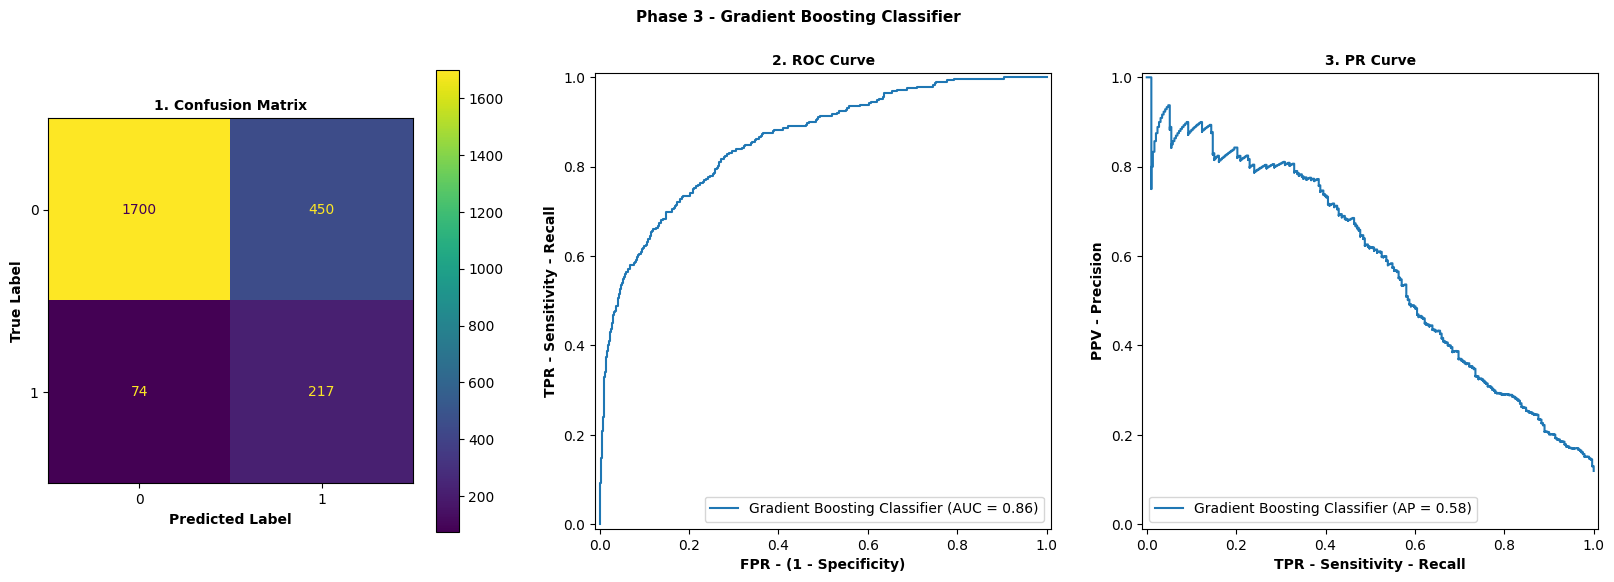

In [373]:
# Model
gra_boost = GradientBoostingClassifier(random_state = 42)  

# CV
param_grid = {
    "learning_rate" : np.linspace(0.001, 0.2, 10, endpoint = True),  # Typical values are 0.01 or 0.001
    'max_depth' : list(range(1, 11)),  # Typical values are between 3 and 10
    # 'n_estimators' : list(range(100, 1101, 100)) # Number of boosting trees. Default = 100.
    }

gra_boost_grid = GridSearchCV(gra_boost , param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
gb_model = gra_boost_grid.fit(X_train_gb, y_train_gb)
display(f'Best Parameter learning_rate : {gb_model.best_params_}')
display(f'Best Estimator : {gb_model.best_estimator_}')

# y_pred
y_pred_gb = gb_model.predict(X_test_gb)

# Accuracy Score
accuracy(dfi, i, gb_model, X_test_gb, y_test_gb, y_pred_gb, "Gradient Boosting Classifier")


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_39440\3688710552.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_gb_sam, plot_size = (10, 5), show = False)


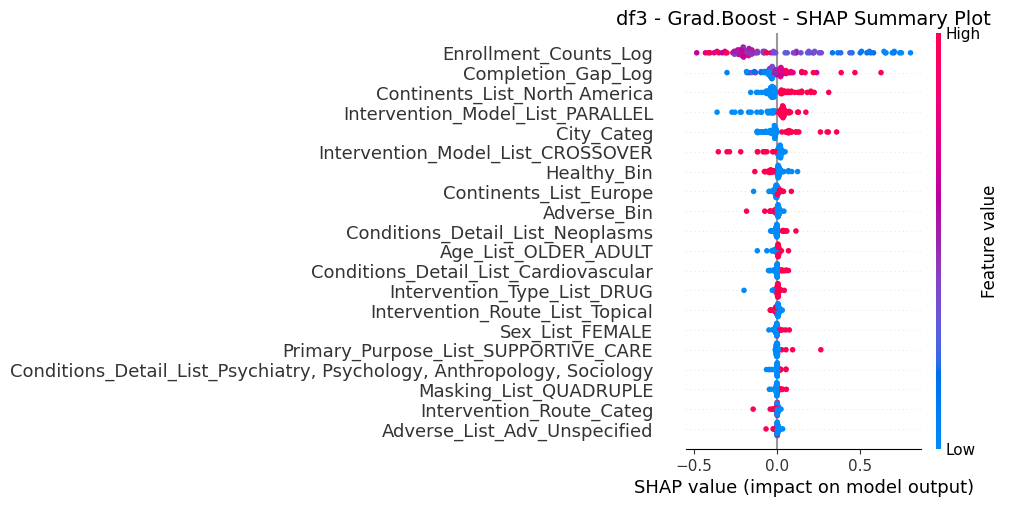

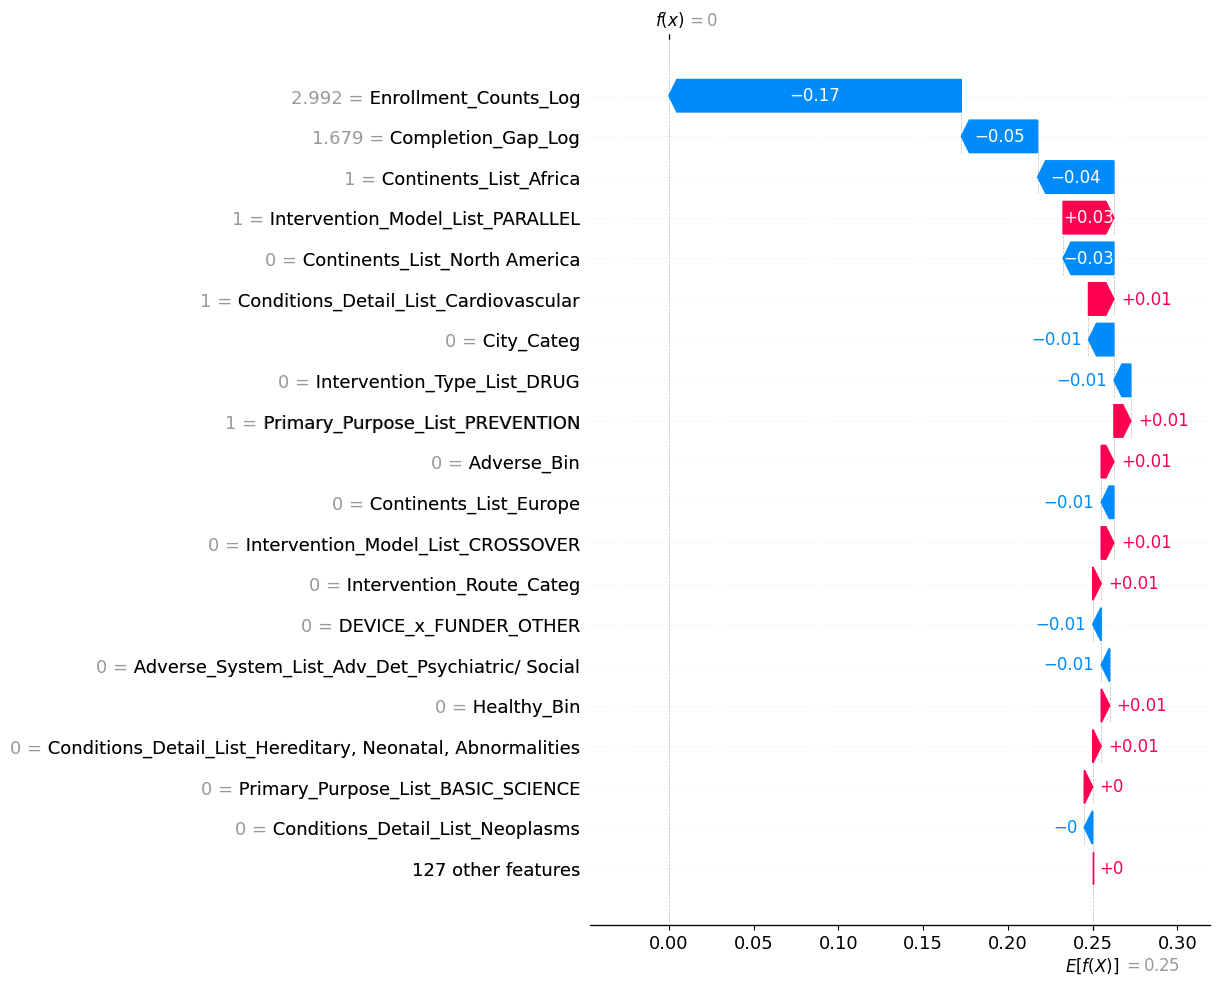

In [374]:
# SHAP
X_test_gb_sam = shap.sample(X_test_gb, 100)
explainer = shap.Explainer(gb_model.best_estimator_.predict, X_test_gb_sam)
shap_values = explainer(X_test_gb_sam)

# Save plot
model = 'gb_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_gb_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Grad.Boost - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### Extreme Gradient Boost

In [375]:
# Built-in Feature Selective models
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()
y_train_xgb = y_train.copy()
y_test_xgb = y_test.copy()

display(X_train_xgb.shape[1])

146

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}
Model : Phase 3 - Gradient Boosting Classifier

a).
Accuracy Score : (True P + True N) / N total :
76.49%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.78      0.85      1137
           1       0.32      0.69      0.44       173

    accuracy                           0.76      1310
   macro avg       0.63      0.73      0.64      1310
weighted avg       0.86      0.76      0.80      1310


).
Matthews Correlation Coefficient (MCC) :
0.3515560636935738

c).
Plots :
ROC AUC : 0.81
PR AUC : 0.5


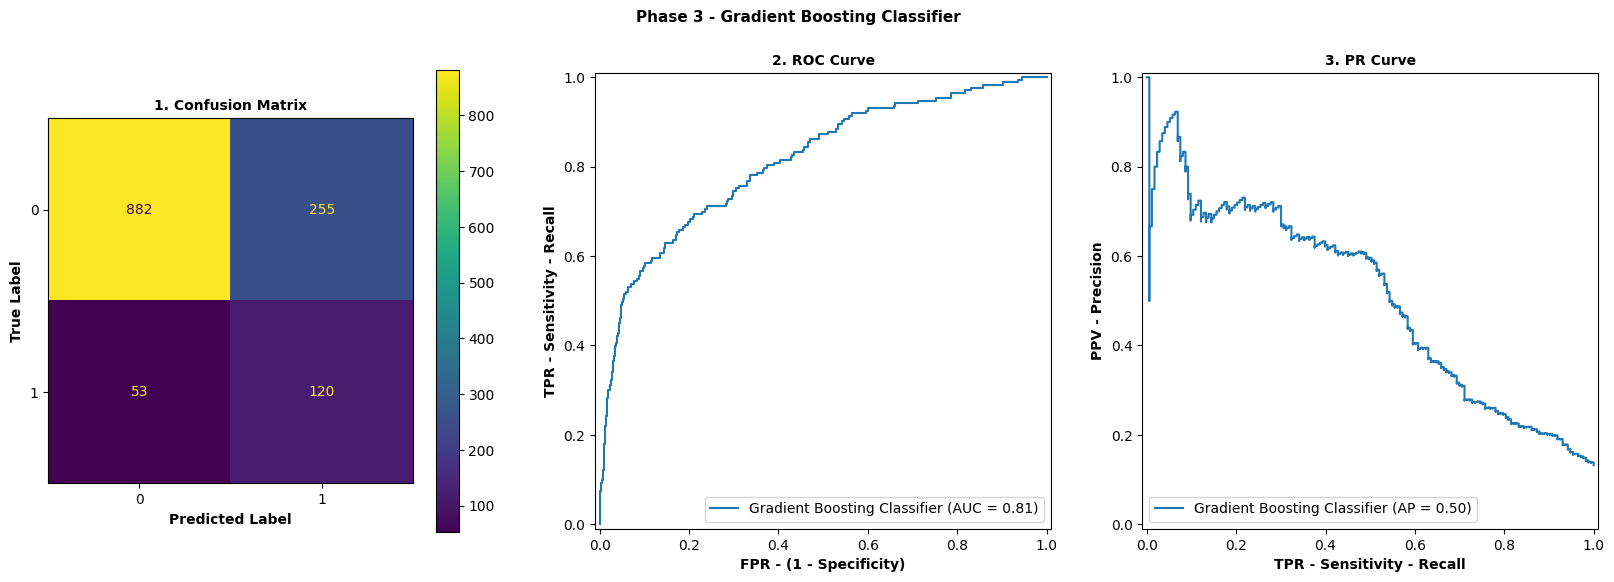

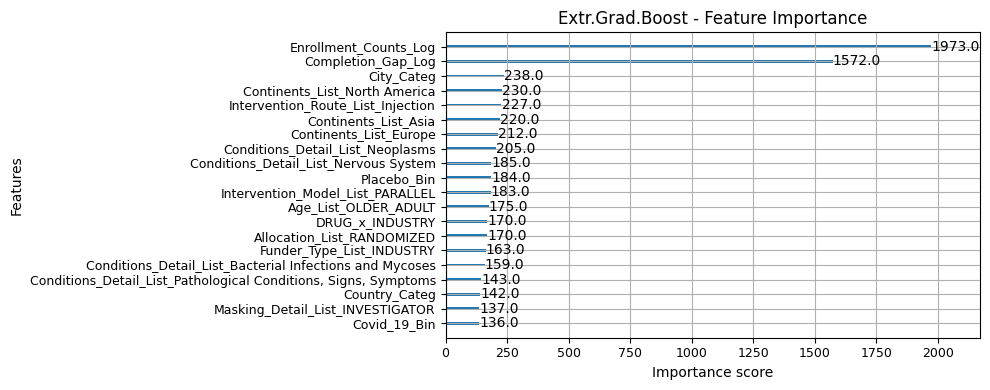

In [376]:
# Model
xgb = XGBClassifier(
    objective='binary:logistic', eval_metric = 'logloss', random_state = 42) # Doc: For classification, ‘log_loss’ is the only option.

# CV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]}

xgb_grid = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1, verbose = 1)

# Final Model
xgb_model = xgb_grid.fit(X_train_xgb, y_train_xgb)
print("Best Parameters:", xgb_model.best_params_)
# print("Best Estimator:", xgb_model.best_estimator_) # too long output. 

# y_pred
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Accuracy Score
accuracy(dfi, i, xgb_model, X_test_xgb, y_test_xgb, y_pred_xgb, "Gradient Boosting Classifier")

# Plot Feature Importances
fig, ax = plt.subplots(figsize = (10, 4), squeeze = True)
plot_importance(xgb_model.best_estimator_ , max_num_features = 20, ax = ax)
plt.yticks(fontsize = 9)
plt.xticks(fontsize = 9)
plt.title("Extr.Grad.Boost - Feature Importance")
plt.tight_layout()
plt.show()


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_39440\3948197801.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_xgb_sam, plot_size = (10, 5), show = False)


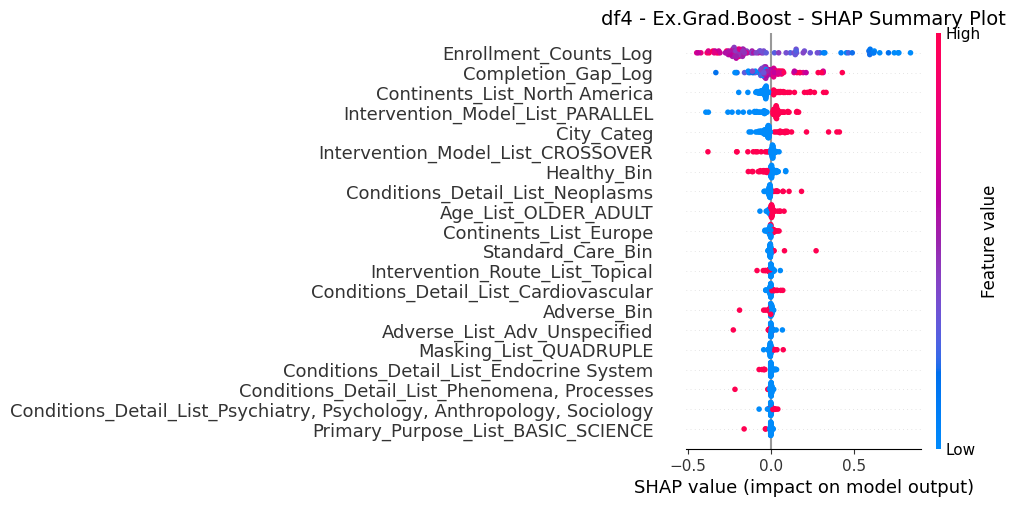

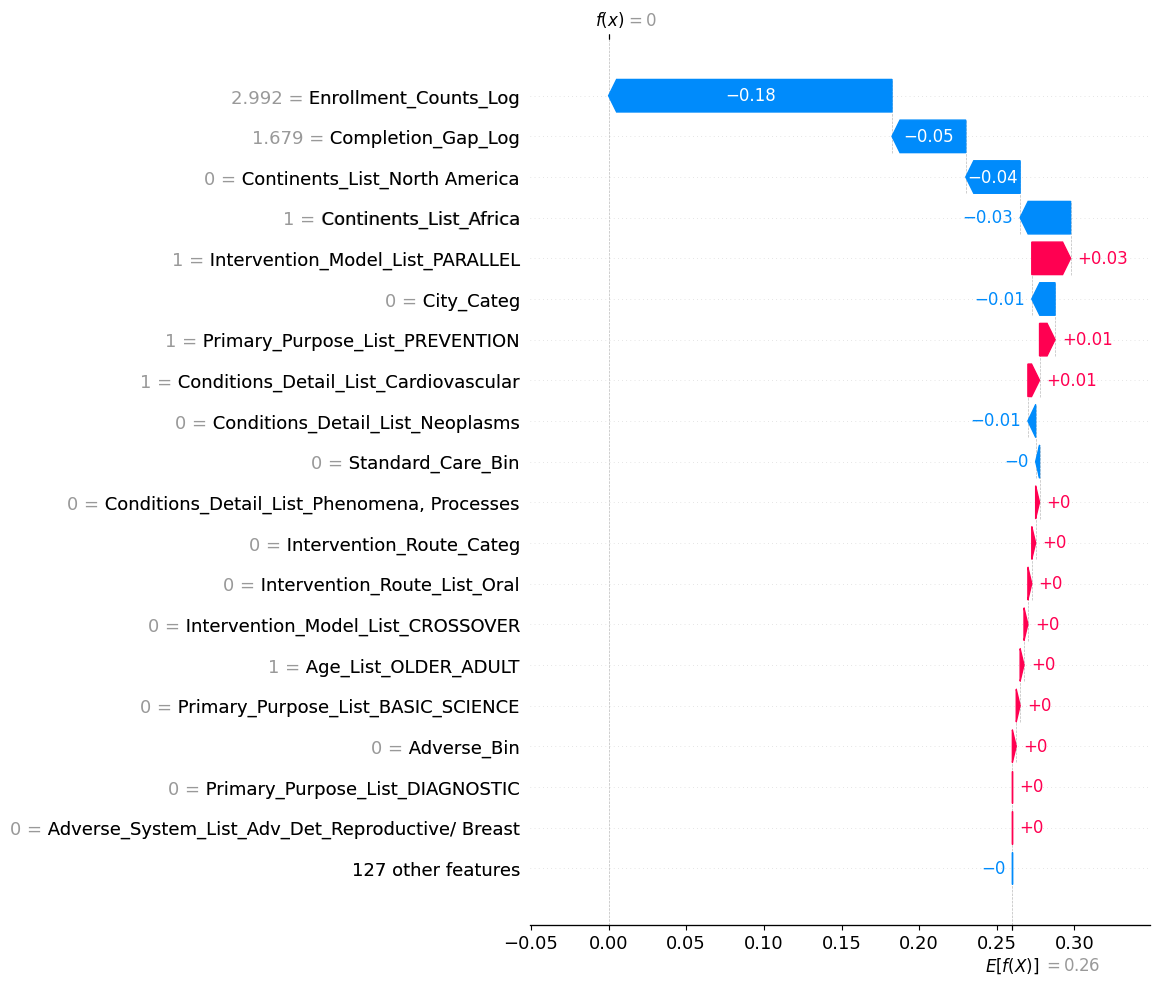

In [221]:
# SHAP
X_test_xgb_sam = shap.sample(X_test_xgb, 100)
explainer = shap.Explainer(xgb_model.best_estimator_.predict, X_test_xgb_sam)
shap_values = explainer(X_test_xgb_sam)

# Save plot
model = 'xgb_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_xgb_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Ex.Grad.Boost - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

# ROC Curve

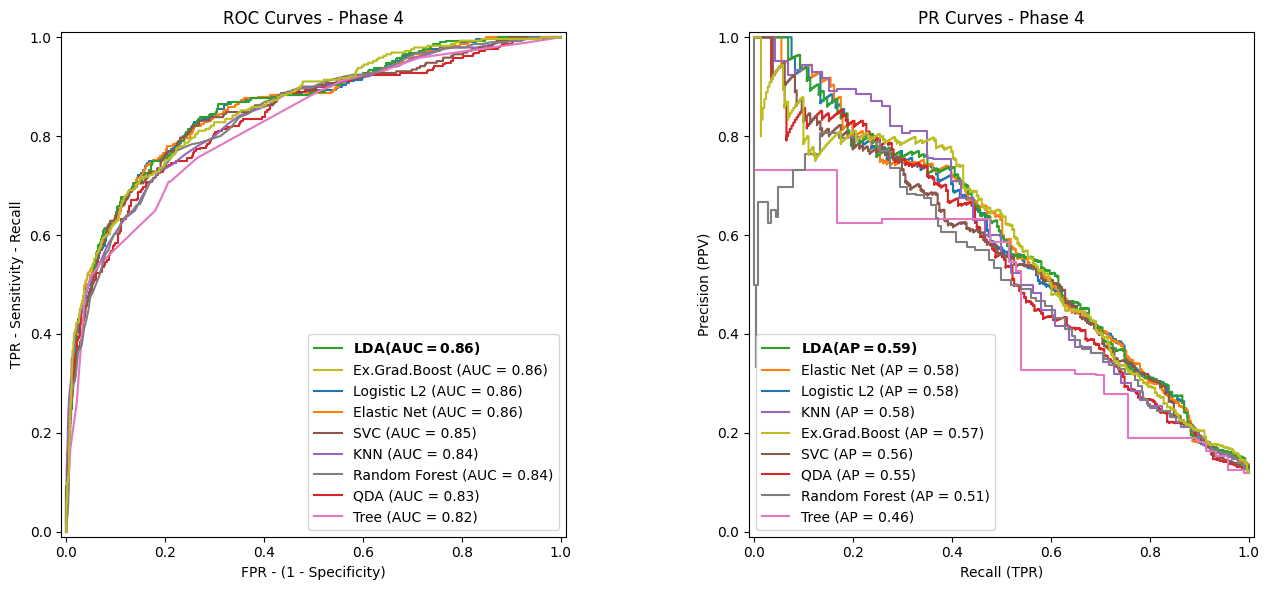

In [241]:
# Save Path
folder_roc = "roc_plots"
os.makedirs(folder_roc, exist_ok=True)
filename = f"roc_df{i}.png"
filepath = os.path.join(folder_roc, filename)

# Models
models = [
    ("Logistic L2", log_model, X_test_log, y_test_log),
    ("Elastic Net", el_model, X_test_el, y_test_el),
    ("LDA", lda_model, X_test_lda, y_test_lda),
    ("QDA", qda_model, X_test_qda, y_test_qda),
    ("KNN", knn_model, X_test_knn, y_test_knn),
    ("SVC", svc_model, X_test_svc, y_test_svc),
    ("Tree", tr_model, X_test_tr, y_test_tr),
    ("Random Forest", rf_model, X_test_rf, y_test_rf),
    # ("Grad.Boost", gb_model, X_test_gb, y_test_gb),
    ("Ex.Grad.Boost", xgb_model, X_test_xgb, y_test_xgb)
]

fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(14, 6))

roc_aucs = []
pr_aucs = []

for original_name, model, X_test_model, y_test_model in models:
    y_score = model.predict_proba(X_test_model)[:, 1]  

# ROC Curve
    auc = roc_auc_score(y_test_model, y_score)
    label_roc = f"{original_name} (AUC = {auc:.2f})"
    roc = RocCurveDisplay.from_estimator(
        model, X_test_model, y_test_model, ax=ax_roc,
        name=label_roc, pos_label = 1  # Completed = 0, Terminated = 1
    )
    roc_aucs.append((auc, label_roc, roc.line_))

# PR Curve
    ap = average_precision_score(y_test_model, y_score)
    label_pr = f"{original_name} (AP = {ap:.2f})"
    pr = PrecisionRecallDisplay.from_estimator(
        model, X_test_model, y_test_model, ax=ax_pr,
        name=label_pr, pos_label=1
    )
    pr_aucs.append((ap, label_pr, pr.line_))

# Sort models at legends
roc_aucs.sort(key=lambda x: x[0], reverse=True)
pr_aucs.sort(key=lambda x: x[0], reverse=True)

# Bold best model
roc_handles = [item[2] for item in roc_aucs]
roc_labels = [f"$\\bf{{{item[1]}}}$" if i == 0 else item[1] for i, item in enumerate(roc_aucs)]
ax_roc.legend(roc_handles, roc_labels, loc="lower right")

pr_handles = [item[2] for item in pr_aucs]
pr_labels = [f"$\\bf{{{item[1]}}}$" if i == 0 else item[1] for i, item in enumerate(pr_aucs)]
ax_pr.legend(pr_handles, pr_labels, loc="lower left")

# withut bold
# ax_roc.legend([item[2] for item in roc_aucs], [item[1] for item in roc_aucs], loc = "lower right")
# ax_pr.legend([item[2] for item in pr_aucs], [item[1] for item in pr_aucs], loc = "lower left")

# Titles/ labels
ax_roc.set_title(f"ROC Curves - Phase {i}")
ax_roc.set_ylabel("TPR - Sensitivity - Recall", fontsize=10)
ax_roc.set_xlabel("FPR - (1 - Specificity)", fontsize=10)

ax_pr.set_title(f"PR Curves - Phase {i}")
ax_pr.set_ylabel("Precision (PPV)", fontsize=10)
ax_pr.set_xlabel("Recall (TPR)", fontsize=10)

plt.tight_layout()

# Save Plot
plt.savefig(filepath, dpi=100, bbox_inches="tight")
plt.show()
plt.close()

